**last update: 08/07/2024**  

This notebook is for Bayesian Gaussian process regression test.

Dataset: sythetic data with middle-range oscillations(decades). Annual mean. 100 models in total. Use first 16 models as example.

Design: Test different kernels with middle-range oscillation data and give evaluations, for sum of periods & poly(periodic transform). Also for some kernels, consider the evolving uncertainty with more observation years.

Note: In this notebook, there is cross validation(leave-one-out). Only use the mean value of other models as prior and plot.

# Package

In [1]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared, ConstantKernel as C
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, ParameterGrid
from scipy.optimize import minimize
from pyswarm import pso
from bayes_opt import BayesianOptimization
from scipy.linalg import cholesky, cho_solve,cho_factor,solve_triangular
from scipy.signal import periodogram, welch
from scipy.fft import fft
from statsmodels.tsa.stattools import acf
from sklearn.gaussian_process.kernels import Kernel, WhiteKernel, Matern, RationalQuadratic as RQ, ConstantKernel as C
from sklearn.preprocessing import PolynomialFeatures
from sklearn.gaussian_process import GaussianProcessRegressor
import pywt
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern, RationalQuadratic, DotProduct
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from bayes_opt import BayesianOptimization, UtilityFunction
from properscoring import crps_gaussian
import gpflow
from gpflow.utilities import print_summary
from gpflow.kernels import RBF, Cosine, Product
from sklearn.preprocessing import StandardScaler

# Data

In [3]:
rainfall = pd.read_csv('../data/rainfall_m.csv')
mod_ids = range(0, 16)
selected_data = rainfall.iloc[:16, 1:]
years = (selected_data.shape[1] // 12)
rainfall_yearly = pd.DataFrame()
for i in range(years):
    rainfall_yearly[i] = selected_data.iloc[:, i*12:(i+1)*12].sum(axis=1)
rainfall_yearly = rainfall_yearly.T
rainfall_yearly.columns = [i+1 for i in range(rainfall_yearly.shape[1])]
rainfall_log = np.log(rainfall_yearly + 1) 
scaler = StandardScaler()
rainfall_yearly = pd.DataFrame(scaler.fit_transform(rainfall_log), columns=rainfall_log.columns)

rainfall_yearly

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-2.439274,1.174882,-0.733376,-0.521282,-1.100109,0.832297,-0.843171,-0.080403,1.918096,-0.136646,-0.036122,-0.464269,0.499056,0.926378,-2.760083,1.089781
1,-0.787676,1.246921,1.582399,0.639681,-0.829540,0.529371,-1.357066,-0.271575,1.486388,-1.128430,-0.299712,-0.778042,0.786228,-0.155227,-2.418165,1.794233
2,-1.279370,0.678254,0.171822,-1.283355,-0.220452,1.310369,-0.551705,-0.360746,1.531186,-1.384989,-0.411965,0.126760,-0.112411,-0.386841,-0.713558,1.899844
3,0.681263,0.318577,2.131191,-0.154067,-0.983916,0.547115,-0.977466,0.121726,0.047151,-2.210545,0.040223,-0.792175,0.230260,-0.649609,-0.557796,1.670634
4,0.824932,0.380310,-0.195647,-0.464396,0.327646,1.225606,0.040750,-0.209179,0.878397,-1.120644,-0.035942,1.310913,-0.933555,-0.995723,1.814829,1.172886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.120060,0.586151,-0.107641,2.273480,-0.260166,0.236297,0.158062,0.725141,-1.362798,0.601651,-0.114530,-1.538919,-1.937932,-0.838045,0.654972,0.295742
96,0.426730,0.372554,-0.813408,0.898837,-0.807246,1.180120,0.162345,-0.226970,0.445007,-0.899512,-0.104813,-2.664643,-2.224963,-1.306272,0.786511,-0.220555
97,-0.374703,0.555211,-0.663636,0.860059,-1.191125,-0.572383,-1.281685,-0.014722,-0.343058,-0.101647,-0.574291,-0.687258,-1.698157,-2.030745,0.580238,0.462812
98,-0.211841,0.084305,-1.462925,-1.274322,-0.777126,0.247174,-1.795521,-0.920524,0.778060,-0.977654,-0.210234,-1.209678,-1.224903,-1.977816,0.813549,-0.028114


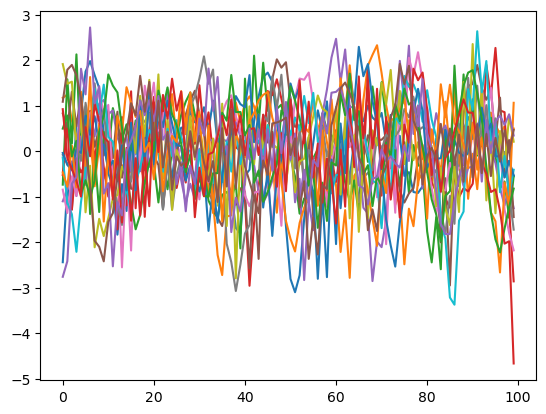

In [4]:
plt.plot(rainfall_yearly)

# Periodic Analysis

In [5]:
# Function to plot and return the top 3 periodicities for each method
def analyze_periodicity(data):
    results = {}
    
    # Convert data to numpy array for FFT
    data = np.asarray(data)
    
    # Fourier Transform
    N = len(data)
    T = 1.0
    yf = fft(data)
    xf = np.fft.fftfreq(N, T)[:N//2]
    fft_amplitudes = 2.0/N * np.abs(yf[0:N//2])
    
    # Avoid division by zero
    non_zero_freqs = xf != 0
    xf = xf[non_zero_freqs]
    fft_amplitudes = fft_amplitudes[non_zero_freqs]
    
    fft_peaks = np.argsort(fft_amplitudes)[-3:]
    fft_periods = 1 / xf[fft_peaks]
    results['FFT'] = fft_periods
    
    # Wavelet Transform
    widths = np.arange(1, 31)
    cwt_matr = pywt.cwt(data, widths, 'mexh')[0]
    wavelet_power = np.sum(cwt_matr**2, axis=1)
    wavelet_peaks = np.argsort(wavelet_power)[-3:]
    wavelet_periods = widths[wavelet_peaks]
    results['Wavelet'] = wavelet_periods
    
    # Autocorrelation
    autocorr = acf(data, nlags=N//2)
    autocorr_peaks = np.argsort(autocorr)[-3:]
    results['Autocorrelation'] = autocorr_peaks
    
    # Power Spectral Density
    freqs, psd = periodogram(data)
    non_zero_freqs = freqs != 0
    freqs = freqs[non_zero_freqs]
    psd = psd[non_zero_freqs]
    
    psd_peaks = np.argsort(psd)[-3:]
    psd_periods = 1 / freqs[psd_peaks]
    results['PSD'] = psd_periods
    
    return results

# Perform the analysis for each of the 16 models
all_results = []
for col in rainfall_yearly.columns:
    data = rainfall_yearly[col]
    results = analyze_periodicity(data)
    all_results.append(results)

# Aggregate and print the results
for method in ['FFT', 'Wavelet', 'Autocorrelation', 'PSD']:
    print(f"Top 3 periodicities for {method}:")
    for i, result in enumerate(all_results):
        print(f"Model {i+1}: {result[method]}")
    print("\n")

Top 3 periodicities for FFT:
Model 1: [20.  10.  12.5]
Model 2: [25.         12.5        14.28571429]
Model 3: [ 2.17391304 20.         14.28571429]
Model 4: [ 2.17391304 25.         14.28571429]
Model 5: [12.5        16.66666667 14.28571429]
Model 6: [50.         14.28571429 20.        ]
Model 7: [ 8.33333333 16.66666667 14.28571429]
Model 8: [12.5        20.         14.28571429]
Model 9: [25.          2.04081633 14.28571429]
Model 10: [ 9.09090909 16.66666667 14.28571429]
Model 11: [20.         12.5        14.28571429]
Model 12: [ 2.22222222 20.         14.28571429]
Model 13: [16.66666667 14.28571429 12.5       ]
Model 14: [ 2.12765957 16.66666667 14.28571429]
Model 15: [12.5         9.09090909 14.28571429]
Model 16: [20.         12.5        14.28571429]


Top 3 periodicities for Wavelet:
Model 1: [5 4 3]
Model 2: [5 3 4]
Model 3: [3 5 4]
Model 4: [6 5 4]
Model 5: [3 5 4]
Model 6: [4 6 5]
Model 7: [5 3 4]
Model 8: [3 5 4]
Model 9: [6 5 4]
Model 10: [5 3 4]
Model 11: [5 3 4]
Model 12:

significant periods: [10, 30]

In [6]:
oos_gcm = rainfall_yearly.iloc[:,0].values
oos_gcm

array([-2.43927392, -0.78767647, -1.27937042,  0.68126317,  0.82493237,
        1.75299027,  1.98436921,  1.67404208,  1.39050444,  0.38727728,
       -0.48151018, -0.78681791, -1.83294007, -0.72183621, -1.31199284,
        0.04952879, -0.06237537,  0.61237585,  0.54085534,  0.41096063,
       -0.2204582 ,  0.12004264, -1.26046982, -0.05358961, -0.58555448,
        0.21390608,  0.51890751,  0.52498047,  0.86293786,  0.63782044,
        0.64072302,  0.96889305,  0.46687698,  1.11317883,  0.16449047,
        0.49831575, -0.6552975 , -0.91153417, -1.68640086, -1.80879567,
       -0.53732524, -0.40424406,  0.65592537,  1.20813027,  1.63320693,
        1.73045899,  1.53057614,  0.69869516, -0.19514381, -1.64615297,
       -2.80804055, -3.09892451, -2.72714784, -1.48972802, -0.51802733,
        0.19208176,  0.90122631,  0.45031685,  1.09807396, -0.1836069 ,
        0.26314798, -1.25142829, -0.09561337, -0.59698545,  0.25771731,
        0.61775704,  0.66675827,  1.00431578,  0.74346301,  0.64

# Function

## tuning

In [47]:
def tune_GPR(mod_ids, Nobs, data, pbounds, kernel_func):
    def gp_target(**params):
        total_lml = 0.0
        for mod_id in mod_ids:
            if mod_id >= data.shape[1]:
                print(f"mod_id {mod_id} is out of bounds for data with {data.shape[1]} columns.")
                continue
            try:
                oos_gcm = data.iloc[:, mod_id].values
            except IndexError as e:
                print(f"IndexError for mod_id {mod_id}: {e}")
                continue

            X_train = np.arange(Nobs).reshape(-1, 1)
            y_train = oos_gcm[:Nobs]

            try:
                kernel = kernel_func(params)
                gp = GaussianProcessRegressor(kernel=kernel, optimizer=None)
                gp.fit(X_train, y_train)
                lml = gp.log_marginal_likelihood()
                if np.isreal(lml):
                    total_lml += lml
                else:
                    total_lml -= np.inf
            except (TypeError, np.linalg.LinAlgError) as e:
                print("Error in kernel construction or GP fitting:", e)
                total_lml -= np.inf

        return total_lml
    
    optimizer = BayesianOptimization(f=gp_target, pbounds=pbounds, random_state=42)
    init_points = 100
    n_iter = 100

    with tqdm(total=init_points + n_iter, desc="Optimization Progress") as pbar:
        try:
            optimizer.maximize(init_points=init_points, n_iter=n_iter)
            pbar.update(init_points + n_iter)
        except Exception as e:
            print("An error occurred during optimization:", e)
            if 'params' in optimizer.max:
                best_params = optimizer.max['params']
                print("Best parameters found during the optimization process: ", best_params)
                kernel = kernel_func(best_params)
                return kernel
            else:
                print("No valid parameters found during the optimization process.")
                return None

    try:
        best_params = optimizer.max['params']
        print("Best parameters found: ", best_params)
        kernel = kernel_func(best_params)
        
        total_lml_train, total_lml_test, total_lml_full = gp_target(**best_params)
        print("Total log marginal likelihood for best parameters: ", total_lml_train, total_lml_test, total_lml_full)
        
        return kernel
    except KeyError:
        print("No valid parameters found after the optimization process.")
        return None

## calculate mean and std

### use gp to obtain posterior

In [38]:
def log_marginal_likelihood_partial(gp, X, y):
    """
    Compute the log marginal likelihood for a given subset of data using a fitted Gaussian Process.
    """
    K = gp.kernel_(X)
    K[np.diag_indices_from(K)] += gp.alpha
    L = np.linalg.cholesky(K)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    
    log_likelihood = -0.5 * np.dot(y.T, alpha)
    log_likelihood -= np.sum(np.log(np.diag(L)))
    log_likelihood -= len(X) / 2 * np.log(2 * np.pi)
    
    return log_likelihood

In [39]:
def GPR_func_sklearn(mod_ids, Nobs, data, best_kernel):
    np.float = np.float64
    total_lml_train = 0.0
    total_lml_test = 0.0
    total_lml_full = 0.0
    
    for mod_id in mod_ids:
        if mod_id >= data.shape[1]:
            print(f"mod_id {mod_id} is out of bounds for data with {data.shape[1]} columns.")
            continue
        
        try:
            oos_gcm = data.iloc[:, mod_id].values
        except IndexError as e:
            print(f"IndexError for mod_id {mod_id}: {e}")
            continue

        X_train = np.arange(Nobs).reshape(-1, 1)
        y_train = oos_gcm[:Nobs]
        X_test = np.arange(Nobs, len(data)).reshape(-1, 1)
        y_test = oos_gcm[Nobs:]
        X_full = np.arange(len(data)).reshape(-1, 1)
        y_full = oos_gcm

        gp = GaussianProcessRegressor(kernel=best_kernel, optimizer=None)
        gp.fit(X_train, y_train)
        lml_train = gp.log_marginal_likelihood()
        if np.isreal(lml_train):
            total_lml_train += lml_train
        else:
            total_lml_train -= np.inf

        lml_test = log_marginal_likelihood_partial(gp, X_test, y_test)
        if np.isreal(lml_test):
            total_lml_test += lml_test
        else:
            total_lml_test -= np.inf

        lml_full = log_marginal_likelihood_partial(gp, X_full, y_full)
        if np.isreal(lml_full):
            total_lml_full += lml_full
        else:
            total_lml_full -= np.inf

    print("total_lml_train:", total_lml_train)
    print("total_lml_test:", total_lml_test)
    print("total_lml_full:", total_lml_full)

    smoothedMean = np.mean(data, axis=1)
    X_train = np.arange(Nobs).reshape(-1, 1)
    y_train = smoothedMean[:Nobs]
    X_full = np.arange(len(data)).reshape(-1, 1)
    y_full = smoothedMean
    gp = GaussianProcessRegressor(kernel=best_kernel, optimizer=None)
    gp.fit(X_train, y_train)
    print("best kernel is:", gp.kernel_)
    prior_mu = smoothedMean
    prior_cov = gp.kernel_(X_full, X_full)
    post_mu, post_cov = gp.predict(X_full, return_cov=True)
    return prior_mu, prior_cov, post_mu, post_cov


## plot

In [40]:
def plot_gpr_results(mod_ids, Nobs, data, best_kernel):
    prior_mu, prior_cov, post_mu, post_cov = GPR_func_sklearn(mod_ids, Nobs, data, best_kernel)
    prior_std = np.sqrt(np.diag(prior_cov))
    post_std = np.sqrt(np.diag(post_cov))
    # prior_mu_obs = prior_mu[:Nobs]

    plt.figure()
    # plt.plot(np.arange(Nobs), prior_mu_obs, 'k', lw=1, label='Prior Observation Mean')
    # plt.fill_between(np.arange(len(data)), prior_mu - 1.96 * prior_std, prior_mu + 1.96 * prior_std, alpha=0.3, color='gray')
    t_pred = np.arange(len(data))
    post_mu_pred = post_mu
    post_std_pred = post_std
    
    plt.axvline(x=Nobs, color='grey', linestyle='--', label='Training/Test Split')
    plt.plot(rainfall_yearly, alpha=0.1, color='blue') #imitate prior region
    plt.fill_between(t_pred, post_mu_pred - 1.96 * post_std_pred, post_mu_pred + 1.96 * post_std_pred, alpha=0.1, color='r', label='95% Posterior Mean')
    plt.plot(t_pred, prior_mu, 'b', lw=2, label='Prior Observation Mean',alpha=1)
    plt.plot(t_pred, post_mu_pred, 'r', lw=2, label='Posterior Mean',alpha=0.6)
    
    
    plt.legend()
    plt.xlabel("Year")
    plt.ylabel("Values")
    # plt.ylim(-5, 5)
    plt.title(f'GPR prediction with {Nobs} years for training')
    plt.show()

## combination

In [41]:
def gpr_model(mod_ids, Nobs, data, pbounds, kernel_func):
    np.float = np.float64
    best_kernel = tune_GPR(mod_ids, Nobs, data, pbounds, kernel_func)
    plot_gpr_results(mod_ids, Nobs, data, best_kernel)

# kernel

Test different kernels. Note that '_' means the sum of kernel, and kernel1kernel2 means kernel1*kernel2. Number means how many kernels we use of the same structure.

With other kernels to be implementation. Such as some kernels to make an addition or product.

## sum of periods

Optimization Progress:   0%|          | 0/200 [00:00<?, ?it/s]

|   iter    |  target   |    c1     |    c2     |    c3     |    c4     |    c5     | dp_sig... |    ls1    |    ls2    |    ls3    |   noise   |   per1    |   per2    |   per3    | rq_alpha  |   rq_ls   |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -862.6    |  3.808    |  9.512    |  7.347    |  6.027    |  1.645    |  1.561    |  0.5903   |  8.663    |  6.015    |  7.081    |  10.41    |  29.4     |  26.65    |  21.24    |  1.826    |
|  2        | -849.6    |  1.916    |  3.112    |  5.295    |  4.376    |  2.983    |  6.119    |  1.404    |  2.929    |  3.67     |  4.561    |  25.7     |  13.99    |  20.28    |  59.25    |  0.474    |
|  3        | -859.5    |  6.115    |  1.788    |  0.744    |  9.494    |  9.66     |  8.084    |  3.053    |  0.9857   |  6.845    |  4.402    |  12.44    |  19.9     |  10.69

Optimization Progress:   0%|          | 0/200 [00:06<?, ?it/s]

An error occurred during optimization: 'x0' must only have one dimension.
Best parameters found during the optimization process:  {'c1': 3.62412951864749, 'c2': 7.602676493597254, 'c3': 0.2424955374345831, 'c4': 1.2491191410184708, 'c5': 0.5554261560153523, 'dp_sigma_0': 0.40824729438738244, 'ls1': 8.556051234269962, 'ls2': 7.039542015206436, 'ls3': 4.746996552582378, 'noise': 0.9792437723493639, 'per1': 19.832317502336647, 'per2': 19.469435415611315, 'per3': 13.464037398200304, 'rq_alpha': 43.39082640730492, 'rq_ls': 3.9910622966297606}
Total log marginal likelihood for best parameters found during the optimization process:  -565.9554421677198


total_lml_train: -565.9554421677198
total_lml_test: -1913.6601213847257
total_lml_full: -2355.930710091378
best kernel is: 1.9**2 * DotProduct(sigma_0=0.408) ** 2 + 2.76**2 * ExpSineSquared(length_scale=8.56, periodicity=19.8) + 0.492**2 * ExpSineSquared(length_scale=7.04, periodicity=19.5) + 1.12**2 * ExpSineSquared(length_scale=4.75, periodicity=13.5) + 0.745**2 * RationalQuadratic(alpha=43.4, length_scale=3.99) + WhiteKernel(noise_level=0.979)


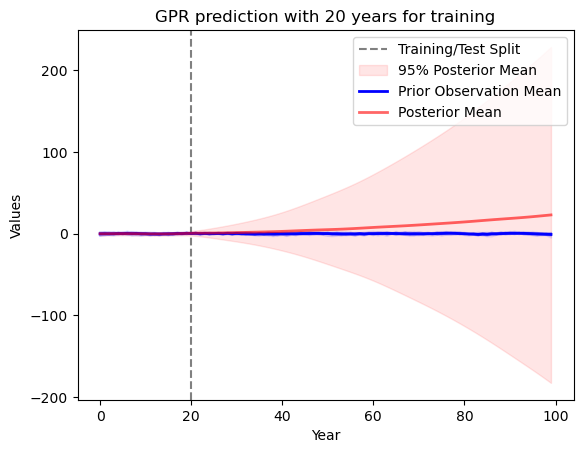

Optimization Progress:   0%|          | 0/200 [00:00<?, ?it/s]

|   iter    |  target   |    c1     |    c2     |    c3     |    c4     |    c5     | dp_sig... |    ls1    |    ls2    |    ls3    |   noise   |   per1    |   per2    |   per3    | rq_alpha  |   rq_ls   |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -1.597e+0 |  3.808    |  9.512    |  7.347    |  6.027    |  1.645    |  1.561    |  0.5903   |  8.663    |  6.015    |  7.081    |  10.41    |  29.4     |  26.65    |  21.24    |  1.826    |
|  2        | -1.555e+0 |  1.916    |  3.112    |  5.295    |  4.376    |  2.983    |  6.119    |  1.404    |  2.929    |  3.67     |  4.561    |  25.7     |  13.99    |  20.28    |  59.25    |  0.474    |
|  3        | -1.545e+0 |  6.115    |  1.788    |  0.744    |  9.494    |  9.66     |  8.084    |  3.053    |  0.9857   |  6.845    |  4.402    |  12.44    |  19.9     |  10.69

Optimization Progress:   0%|          | 0/200 [00:07<?, ?it/s]

|  100      | -1.511e+0 |  3.728    |  4.022    |  6.985    |  3.947    |  4.542    |  2.376    |  3.739    |  2.28     |  0.7412   |  6.035    |  23.36    |  22.39    |  19.27    |  37.98    |  8.635    |
An error occurred during optimization: 'x0' must only have one dimension.
Best parameters found during the optimization process:  {'c1': 3.62412951864749, 'c2': 7.602676493597254, 'c3': 0.2424955374345831, 'c4': 1.2491191410184708, 'c5': 0.5554261560153523, 'dp_sigma_0': 0.40824729438738244, 'ls1': 8.556051234269962, 'ls2': 7.039542015206436, 'ls3': 4.746996552582378, 'noise': 0.9792437723493639, 'per1': 19.832317502336647, 'per2': 19.469435415611315, 'per3': 13.464037398200304, 'rq_alpha': 43.39082640730492, 'rq_ls': 3.9910622966297606}
Total log marginal likelihood for best parameters found during the optimization process:  -1016.6277729540889


total_lml_train: -1016.6277729540889
total_lml_test: -1499.3279262076844
total_lml_full: -2355.930710091378
best kernel is: 1.9**2 * DotProduct(sigma_0=0.408) ** 2 + 2.76**2 * ExpSineSquared(length_scale=8.56, periodicity=19.8) + 0.492**2 * ExpSineSquared(length_scale=7.04, periodicity=19.5) + 1.12**2 * ExpSineSquared(length_scale=4.75, periodicity=13.5) + 0.745**2 * RationalQuadratic(alpha=43.4, length_scale=3.99) + WhiteKernel(noise_level=0.979)


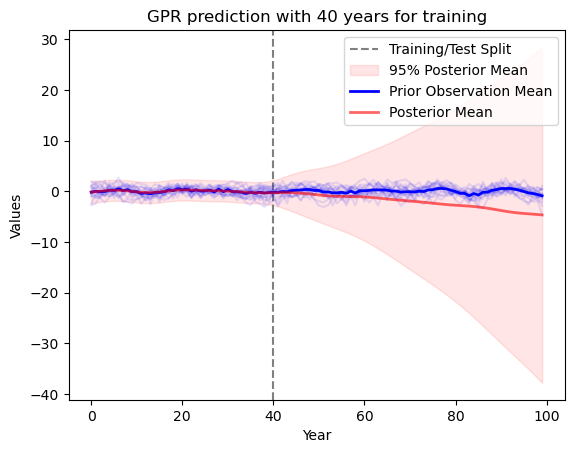

Optimization Progress:   0%|          | 0/200 [00:00<?, ?it/s]

|   iter    |  target   |    c1     |    c2     |    c3     |    c4     |    c5     | dp_sig... |    ls1    |    ls2    |    ls3    |   noise   |   per1    |   per2    |   per3    | rq_alpha  |   rq_ls   |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -2.3e+03  |  3.808    |  9.512    |  7.347    |  6.027    |  1.645    |  1.561    |  0.5903   |  8.663    |  6.015    |  7.081    |  10.41    |  29.4     |  26.65    |  21.24    |  1.826    |
|  2        | -2.233e+0 |  1.916    |  3.112    |  5.295    |  4.376    |  2.983    |  6.119    |  1.404    |  2.929    |  3.67     |  4.561    |  25.7     |  13.99    |  20.28    |  59.25    |  0.474    |
|  3        | -2.214e+0 |  6.115    |  1.788    |  0.744    |  9.494    |  9.66     |  8.084    |  3.053    |  0.9857   |  6.845    |  4.402    |  12.44    |  19.9     |  10.69

Optimization Progress:   0%|          | 0/200 [00:07<?, ?it/s]

|  100      | -2.192e+0 |  3.728    |  4.022    |  6.985    |  3.947    |  4.542    |  2.376    |  3.739    |  2.28     |  0.7412   |  6.035    |  23.36    |  22.39    |  19.27    |  37.98    |  8.635    |
An error occurred during optimization: 'x0' must only have one dimension.
Best parameters found during the optimization process:  {'c1': 3.62412951864749, 'c2': 7.602676493597254, 'c3': 0.2424955374345831, 'c4': 1.2491191410184708, 'c5': 0.5554261560153523, 'dp_sigma_0': 0.40824729438738244, 'ls1': 8.556051234269962, 'ls2': 7.039542015206436, 'ls3': 4.746996552582378, 'noise': 0.9792437723493639, 'per1': 19.832317502336647, 'per2': 19.469435415611315, 'per3': 13.464037398200304, 'rq_alpha': 43.39082640730492, 'rq_ls': 3.9910622966297606}
Total log marginal likelihood for best parameters found during the optimization process:  -1467.2152161672952


total_lml_train: -1467.2152161672952
total_lml_test: -1071.3707791792963
total_lml_full: -2355.930710091378
best kernel is: 1.9**2 * DotProduct(sigma_0=0.408) ** 2 + 2.76**2 * ExpSineSquared(length_scale=8.56, periodicity=19.8) + 0.492**2 * ExpSineSquared(length_scale=7.04, periodicity=19.5) + 1.12**2 * ExpSineSquared(length_scale=4.75, periodicity=13.5) + 0.745**2 * RationalQuadratic(alpha=43.4, length_scale=3.99) + WhiteKernel(noise_level=0.979)


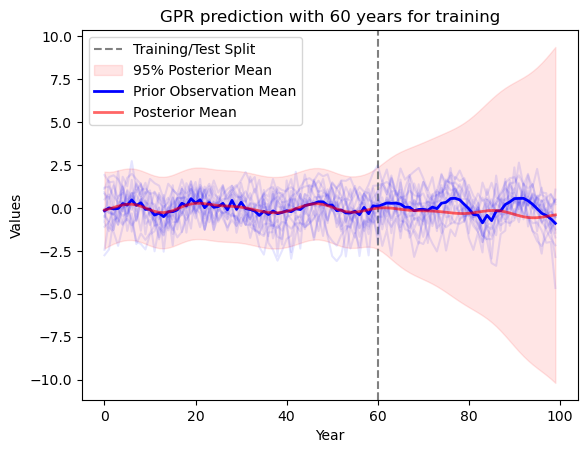

Optimization Progress:   0%|          | 0/200 [00:00<?, ?it/s]

|   iter    |  target   |    c1     |    c2     |    c3     |    c4     |    c5     | dp_sig... |    ls1    |    ls2    |    ls3    |   noise   |   per1    |   per2    |   per3    | rq_alpha  |   rq_ls   |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -2.991e+0 |  3.808    |  9.512    |  7.347    |  6.027    |  1.645    |  1.561    |  0.5903   |  8.663    |  6.015    |  7.081    |  10.41    |  29.4     |  26.65    |  21.24    |  1.826    |
|  2        | -2.9e+03  |  1.916    |  3.112    |  5.295    |  4.376    |  2.983    |  6.119    |  1.404    |  2.929    |  3.67     |  4.561    |  25.7     |  13.99    |  20.28    |  59.25    |  0.474    |
|  3        | -2.875e+0 |  6.115    |  1.788    |  0.744    |  9.494    |  9.66     |  8.084    |  3.053    |  0.9857   |  6.845    |  4.402    |  12.44    |  19.9     |  10.69

Optimization Progress:   0%|          | 0/200 [00:09<?, ?it/s]

|  100      | -2.865e+0 |  3.728    |  4.022    |  6.985    |  3.947    |  4.542    |  2.376    |  3.739    |  2.28     |  0.7412   |  6.035    |  23.36    |  22.39    |  19.27    |  37.98    |  8.635    |
An error occurred during optimization: 'x0' must only have one dimension.
Best parameters found during the optimization process:  {'c1': 3.62412951864749, 'c2': 7.602676493597254, 'c3': 0.2424955374345831, 'c4': 1.2491191410184708, 'c5': 0.5554261560153523, 'dp_sigma_0': 0.40824729438738244, 'ls1': 8.556051234269962, 'ls2': 7.039542015206436, 'ls3': 4.746996552582378, 'noise': 0.9792437723493639, 'per1': 19.832317502336647, 'per2': 19.469435415611315, 'per3': 13.464037398200304, 'rq_alpha': 43.39082640730492, 'rq_ls': 3.9910622966297606}
Total log marginal likelihood for best parameters found during the optimization process:  -1903.7990884404762


total_lml_train: -1903.7990884404762
total_lml_test: -628.2840945356944
total_lml_full: -2355.930710091378
best kernel is: 1.9**2 * DotProduct(sigma_0=0.408) ** 2 + 2.76**2 * ExpSineSquared(length_scale=8.56, periodicity=19.8) + 0.492**2 * ExpSineSquared(length_scale=7.04, periodicity=19.5) + 1.12**2 * ExpSineSquared(length_scale=4.75, periodicity=13.5) + 0.745**2 * RationalQuadratic(alpha=43.4, length_scale=3.99) + WhiteKernel(noise_level=0.979)


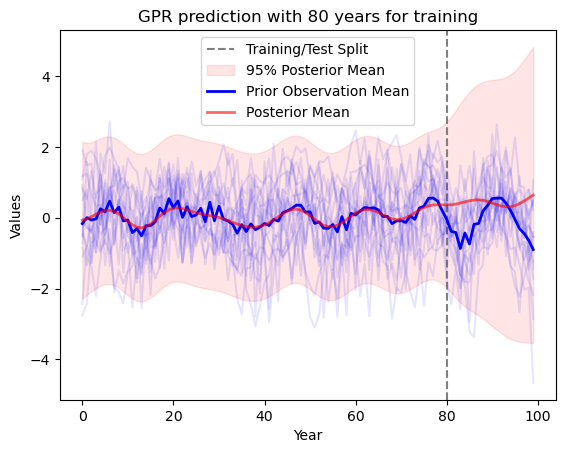

In [17]:
def create_kernel(best_params):
    kernel = (
        C(best_params['c1']) * (DotProduct(sigma_0=best_params['dp_sigma_0']) ** 2) +
        C(best_params['c2']) * ExpSineSquared(length_scale=best_params['ls1'], periodicity=best_params['per1']) +
        C(best_params['c3']) * ExpSineSquared(length_scale=best_params['ls2'], periodicity=best_params['per2']) +
        C(best_params['c4']) * ExpSineSquared(length_scale=best_params['ls3'], periodicity=best_params['per3']) +
        C(best_params['c5']) * RationalQuadratic(length_scale=best_params['rq_ls'], alpha=best_params['rq_alpha']) +
        WhiteKernel(noise_level=best_params['noise'])
    )
    return kernel

pbounds = {
    'c1': (1e-1, 1e1),
    'c2': (1e-1, 1e1),
    'c3': (1e-1, 1e1),
    'c4': (1e-1, 1e1),
    'c5': (1e-1, 1e1),
    'ls1': (1e-2, 1e1),
    'per1': (10, 30),
    'ls2': (1e-2, 1e1),
    'per2': (10, 30),
    'ls3': (1e-2, 1e1),
    'per3': (10, 30),
    'noise': (1e-3, 1e1),
    'dp_sigma_0': (1e-3, 1e1),
    'rq_alpha': (1e-2, 1e2),
    'rq_ls': (1e-2, 1e1),
}

gpr_model(mod_ids, 20, rainfall_yearly, pbounds, create_kernel)
gpr_model(mod_ids, 40, rainfall_yearly, pbounds, create_kernel)
gpr_model(mod_ids, 60, rainfall_yearly, pbounds, create_kernel)
gpr_model(mod_ids, 80, rainfall_yearly, pbounds, create_kernel)

Optimization Progress:   0%|          | 0/200 [00:00<?, ?it/s]

|   iter    |  target   |    c1     |    c2     |    c3     |    c4     |    c5     | dp_sig... |    ls1    |    ls2    |    ls3    |   noise   |   per1    |   per2    |   per3    | rq_alpha  |   rq_ls   |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -2.991e+0 |  3.808    |  9.512    |  7.347    |  6.027    |  1.645    |  1.561    |  0.5903   |  8.663    |  6.015    |  7.081    |  10.41    |  29.4     |  26.65    |  21.24    |  1.826    |
|  2        | -2.9e+03  |  1.916    |  3.112    |  5.295    |  4.376    |  2.983    |  6.119    |  1.404    |  2.929    |  3.67     |  4.561    |  25.7     |  13.99    |  20.28    |  59.25    |  0.474    |
|  3        | -2.875e+0 |  6.115    |  1.788    |  0.744    |  9.494    |  9.66     |  8.084    |  3.053    |  0.9857   |  6.845    |  4.402    |  12.44    |  19.9     |  10.69

Optimization Progress:   0%|          | 0/200 [00:09<?, ?it/s]

Total log marginal likelihood for best parameters found during the optimization process:  -1903.7990884404762


total_lml_train: -1903.7990884404762
total_lml_test: -628.2840945356944
total_lml_full: -2355.930710091378
best kernel is: 1.9**2 * DotProduct(sigma_0=0.408) ** 2 + 2.76**2 * ExpSineSquared(length_scale=8.56, periodicity=19.8) + 0.492**2 * ExpSineSquared(length_scale=7.04, periodicity=19.5) + 1.12**2 * ExpSineSquared(length_scale=4.75, periodicity=13.5) + 0.745**2 * RationalQuadratic(alpha=43.4, length_scale=3.99) + WhiteKernel(noise_level=0.979)


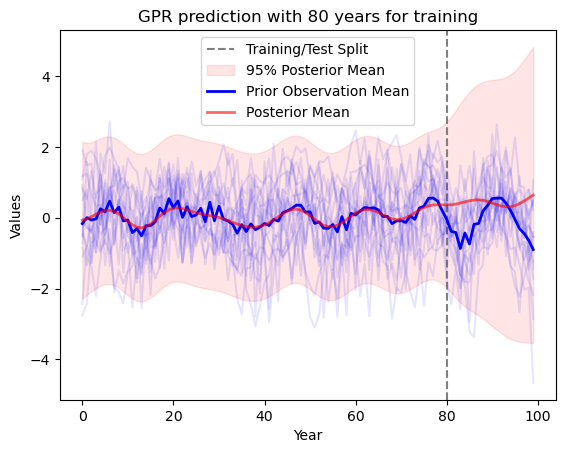

In [18]:
def pe3_poly_rq(best_params):
    kernel = (
        C(best_params['c1']) * (DotProduct(sigma_0=best_params['dp_sigma_0']) ** 2) +
        C(best_params['c2']) * ExpSineSquared(length_scale=best_params['ls1'], periodicity=best_params['per1']) +
        C(best_params['c3']) * ExpSineSquared(length_scale=best_params['ls2'], periodicity=best_params['per2']) +
        C(best_params['c4']) * ExpSineSquared(length_scale=best_params['ls3'], periodicity=best_params['per3']) +
        C(best_params['c5']) * RationalQuadratic(length_scale=best_params['rq_ls'], alpha=best_params['rq_alpha']) +
        WhiteKernel(noise_level=best_params['noise'])
    )
    return kernel

pbounds = {
        'c1': (1e-1, 1e1),
        'c2': (1e-1, 1e1),
        'c3': (1e-1, 1e1),
        'c4': (1e-1, 1e1),
        'c5': (1e-1, 1e1),
        'ls1': (1e-2, 1e1),
        'per1': (10, 30),
        'ls2': (1e-2, 1e1),
        'per2': (10, 30),
        'ls3': (1e-2, 1e1),
        'per3': (10, 30),
        'noise': (1e-3, 1e1),
        'dp_sigma_0': (1e-3, 1e1),
        'rq_alpha': (1e-2, 1e2),
        'rq_ls': (1e-2, 1e1),
    }
gpr_model(mod_ids, 80, rainfall_yearly, pbounds, pe3_poly_rq)

Optimization Progress:   0%|          | 0/200 [00:00<?, ?it/s]

|   iter    |  target   |    c1     |    c2     |    c3     |    c4     |    c5     | dp_sig... |    ls1    |    ls2    |    ls3    |   noise   |   per1    |   per2    |   per3    |   rbf_c   |  rbf_ls   | rq_alpha1 | rq_alpha2 | rq_alpha3 |  rq_ls1   |  rq_ls2   |  rq_ls3   |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -3.297e+0 |  3.808    |  9.512    |  7.347    |  6.027    |  1.645    |  1.561    |  0.5903   |  8.663    |  6.015    |  7.081    |  10.41    |  29.4     |  26.65    |  2.202    |  1.826    |  18.35    |  30.43    |  52.48    |  4.325    |  2.919    |  6.122    |
|  2        | -3.071e+0 |  1.481    |  2.992    |  3.727    |  4.615    |  7.873    |  1.998    |  5.147    |  5.928    |  0.474    |  6.076    |  13.41    |  11.3   

Optimization Progress:   0%|          | 0/200 [00:14<?, ?it/s]

|  100      | -3.09e+03 |  7.743    |  0.369    |  0.7455   |  4.693    |  9.101    |  5.387    |  4.983    |  1.064    |  6.571    |  8.221    |  17.61    |  25.51    |  29.29    |  2.117    |  5.238    |  28.72    |  79.29    |  57.76    |  6.349    |  7.981    |  3.966    |
An error occurred during optimization: 'x0' must only have one dimension.
Best parameters found during the optimization process:  {'c1': 1.5973436044758522, 'c2': 2.3306376065172274, 'c3': 2.5845699472689505, 'c4': 8.521098972627264, 'c5': 5.656105603996997, 'dp_sigma_0': 5.2343857228322905, 'ls1': 1.1565410299734826, 'ls2': 8.602795536560855, 'ls3': 7.230914889052753, 'noise': 0.6776159506381159, 'per1': 24.156701944595373, 'per2': 20.870764346852923, 'per3': 11.634506914935566, 'rbf_c': 4.637176351133699, 'rbf_ls': 4.85211590842917, 'rq_alpha1': 16.585796270925943, 'rq_alpha2': 94.57035771855823, 'rq_alpha3': 84.99903739435139, 'rq_ls1': 6.693533149917792, 'rq_ls2': 4.628332654396066, 'rq_ls3': 4.12353776042924

total_lml_train: -2079.1460886936634
total_lml_test: -662.5279725789984
total_lml_full: -2556.9722155741365
best kernel is: 1.26**2 * DotProduct(sigma_0=5.23) ** 2 + 1.53**2 * RationalQuadratic(alpha=16.6, length_scale=6.69) * ExpSineSquared(length_scale=1.16, periodicity=24.2) + 1.61**2 * ExpSineSquared(length_scale=8.6, periodicity=20.9) * RationalQuadratic(alpha=94.6, length_scale=4.63) + 2.92**2 * ExpSineSquared(length_scale=7.23, periodicity=11.6) * RationalQuadratic(alpha=85, length_scale=4.12) + 2.38**2 * RationalQuadratic(alpha=16.6, length_scale=6.69) + 2.15**2 * RBF(length_scale=4.85) + WhiteKernel(noise_level=0.678)


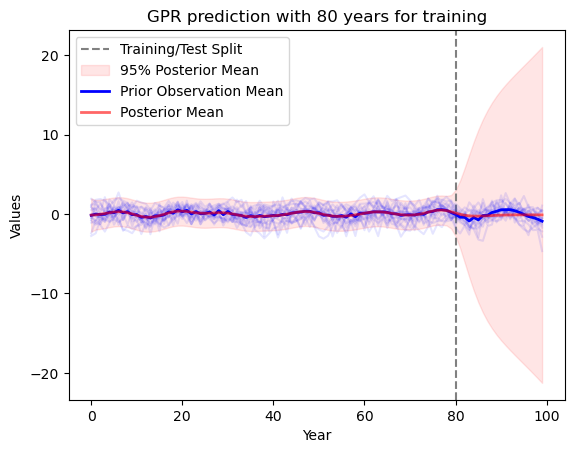

In [48]:
def rqpe2_poly_rq(best_params):
    kernel = (
        C(best_params['c1']) * (DotProduct(sigma_0=best_params['dp_sigma_0']) ** 2) +
        C(best_params['c2']) * RationalQuadratic(length_scale=best_params['rq_ls1'], alpha=best_params['rq_alpha1']) * ExpSineSquared(length_scale=best_params['ls1'], periodicity=best_params['per1']) +
        C(best_params['c3']) * ExpSineSquared(length_scale=best_params['ls2'], periodicity=best_params['per2']) * RationalQuadratic(length_scale=best_params['rq_ls2'], alpha=best_params['rq_alpha2']) +
        C(best_params['c4']) * ExpSineSquared(length_scale=best_params['ls3'], periodicity=best_params['per3']) * RationalQuadratic(length_scale=best_params['rq_ls3'], alpha=best_params['rq_alpha3']) +
        C(best_params['c5']) * RationalQuadratic(length_scale=best_params['rq_ls1'], alpha=best_params['rq_alpha1']) + C(best_params['rbf_c']) * RBF(length_scale=best_params['rbf_ls']) +
        WhiteKernel(noise_level=best_params['noise'])
    )
    return kernel

pbounds = {
    'c1': (1e-1, 1e1),
    'c2': (1e-1, 1e1),
    'c3': (1e-1, 1e1),
    'c4': (1e-1, 1e1),
    'c5': (1e-1, 1e1),
    'ls1': (1e-2, 1e1),
    'per1': (10, 30),
    'ls2': (1e-2, 1e1),
    'per2': (10, 30),
    'ls3': (1e-2, 1e1),
    'per3': (10, 30),
    'noise': (1e-3, 1e1),
    'dp_sigma_0': (1e-3, 1e1),
    'rq_alpha1': (1e-2, 1e2),
    'rq_ls1': (1e-2, 1e1),
    'rq_alpha2': (1e-2, 1e2),
    'rq_ls2': (1e-2, 1e1),
    'rq_alpha3': (1e-2, 1e2),
    'rq_ls3': (1e-2, 1e1),
    'rbf_c': (1e-1, 1e1),
    'rbf_ls': (1e-2, 1e1),
}
gpr_model(mod_ids, 80, rainfall_yearly, pbounds, rqpe2_poly_rq)

Optimization Progress:   0%|          | 0/200 [00:00<?, ?it/s]

|   iter    |  target   |    c1     |    c2     |    ls1    |    ls2    |    ls3    |   noise   |   per1    |   per2    |   per3    |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        | -2.207e+0 |  3.808    |  9.512    |  7.323    |  5.991    |  1.569    |  1.561    |  11.16    |  27.32    |  22.02    |
|  2        | -2.173e+0 |  7.11     |  0.3038   |  9.699    |  8.326    |  2.131    |  1.819    |  13.67    |  16.08    |  20.5     |
|  3        | -2.463e+0 |  4.376    |  2.983    |  6.122    |  1.404    |  2.929    |  3.664    |  19.12    |  25.7     |  13.99    |
|  4        | -2.033e+0 |  5.191    |  5.965    |  0.474    |  6.079    |  1.714    |  0.6515   |  28.98    |  29.31    |  26.17    |
|  5        | -2.595e+0 |  3.116    |  1.067    |  6.845    |  4.407    |  1.229    |  4.952    |  10.69    |  28.19    |  15.18    |
|  6        | -2.973e+0 |  6.659    |  3.186    |  5.205    | 

Optimization Progress:   0%|          | 0/200 [00:07<?, ?it/s]

|  100      | -2.444e+0 |  8.571    |  8.319    |  3.978    |  6.684    |  2.058    |  2.932    |  27.93    |  10.26    |  11.71    |
An error occurred during optimization: 'x0' must only have one dimension.
Best parameters found during the optimization process:  {'c1': 3.631857934266534, 'c2': 2.8812516459050697, 'ls1': 5.431533870750902, 'ls2': 1.4178330074978789, 'ls3': 8.023947837732857, 'noise': 0.7464318861540284, 'per1': 29.737738732010346, 'per2': 25.444895385933147, 'per3': 13.974313630683447}


total_lml_train: -1892.7375952407685
total_lml_test: -624.2618328628149
total_lml_full: -2380.8362487022155
best kernel is: 1.91**2 * DotProduct(sigma_0=1) ** 2 + 1.7**2 * ExpSineSquared(length_scale=5.43, periodicity=29.7) + 1.7**2 * ExpSineSquared(length_scale=1.42, periodicity=25.4) + 1.7**2 * ExpSineSquared(length_scale=8.02, periodicity=14) + WhiteKernel(noise_level=0.746)


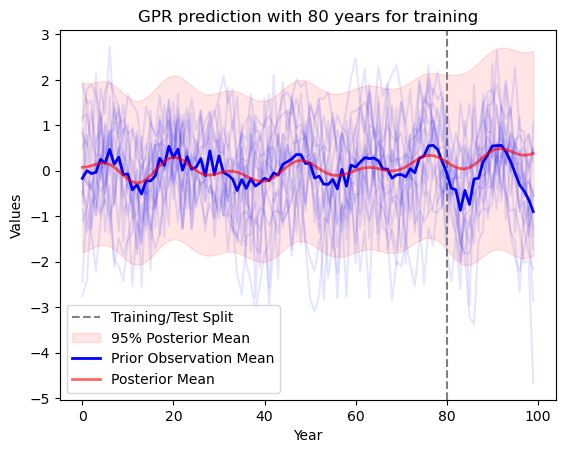

In [49]:
def pe3_poly(best_params):
    kernel = (
        C(best_params['c1']) * (DotProduct() ** 2) +
        C(best_params['c2']) * ExpSineSquared(length_scale=best_params['ls1'], periodicity=best_params['per1']) +
        C(best_params['c2']) * ExpSineSquared(length_scale=best_params['ls2'], periodicity=best_params['per2']) +
        C(best_params['c2']) * ExpSineSquared(length_scale=best_params['ls3'], periodicity=best_params['per3']) +
        WhiteKernel(noise_level=best_params['noise'])
    )
    return kernel

pbounds = {
    'c1': (1e-1, 1e1),
    'c2': (1e-1, 1e1),
    'ls1': (1e-2, 1e1),
    'per1': (10, 30),
    'ls2': (1e-2, 1e1),
    'per2': (10, 30),
    'ls3': (1e-2, 1e1),
    'per3': (10, 30),
    'noise': (1e-3, 1e1),
}
gpr_model(mod_ids, 80, rainfall_yearly, pbounds, pe3_poly)

Optimization Progress:   0%|          | 0/200 [00:00<?, ?it/s]

|   iter    |  target   |    c1     |    c2     |    c3     |    c4     | dp_sig... |    ls1    |    ls2    |    ls3    |   noise   |   per1    |   per2    |   per3    |  rbf_ls   | rbf_rq_c  | rq_alpha1 | rq_alpha2 | rq_alpha3 | rq_alp... |  rq_ls1   |  rq_ls2   |  rq_ls3   | rq_ls_rbf |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -3.208e+0 |  3.808    |  9.512    |  7.347    |  6.027    |  1.561    |  1.568    |  0.5903   |  8.663    |  6.012    |  24.16    |  10.41    |  29.4     |  8.326    |  2.202    |  18.19    |  18.35    |  30.43    |  52.48    |  4.325    |  2.919    |  6.122    |  1.404    |
|  2        | -3.348e+0 |  2.992    |  3.727    |  4.615    |  7.873    |  1.998    |  5.147    |  5.928    |  0.474    |  6.076  

Optimization Progress:   0%|          | 0/200 [00:12<?, ?it/s]

|  99       | -2.9e+03  |  1.506    |  3.545    |  4.558    |  7.513    |  6.512    |  6.213    |  3.53     |  8.416    |  4.713    |  29.58    |  22.68    |  12.53    |  6.765    |  3.319    |  68.64    |  6.973    |  17.5     |  85.58    |  2.28     |  8.372    |  2.8      |  6.432    |
|  100      | -3.131e+0 |  6.972    |  5.175    |  3.123    |  2.205    |  0.3329   |  3.046    |  6.535    |  9.384    |  8.712    |  25.32    |  25.77    |  23.3     |  2.61     |  9.081    |  67.08    |  56.05    |  11.11    |  44.71    |  4.609    |  8.647    |  5.471    |  3.81     |
An error occurred during optimization: 'x0' must only have one dimension.
Best parameters found during the optimization process:  {'c1': 9.118179126489041, 'c2': 8.243118704939373, 'c3': 9.503019141590048, 'c4': 7.2846231330447635, 'dp_sigma_0': 6.1345385441619635, 'ls1': 4.188247932543282, 'ls2': 9.327957548706593, 'ls3': 8.66197825610908, 'noise': 0.4531414823917879, 'per1': 10.52733948994504, 'per2': 17.5292673375

total_lml_train: -2092.992305234382
total_lml_test: -684.1512921859354
total_lml_full: -2560.5044695843753
best kernel is: 3.02**2 * DotProduct(sigma_0=6.13) ** 2 + 2.87**2 * RationalQuadratic(alpha=59.4, length_scale=8.38) * ExpSineSquared(length_scale=4.19, periodicity=10.5) + 3.08**2 * ExpSineSquared(length_scale=9.33, periodicity=17.5) * RationalQuadratic(alpha=38.1, length_scale=4.69) + 2.7**2 * ExpSineSquared(length_scale=8.66, periodicity=26.2) * RationalQuadratic(alpha=97, length_scale=4.15) + 1.26**2 * RBF(length_scale=9.87) * RationalQuadratic(alpha=84.2, length_scale=2.74) + WhiteKernel(noise_level=0.453)


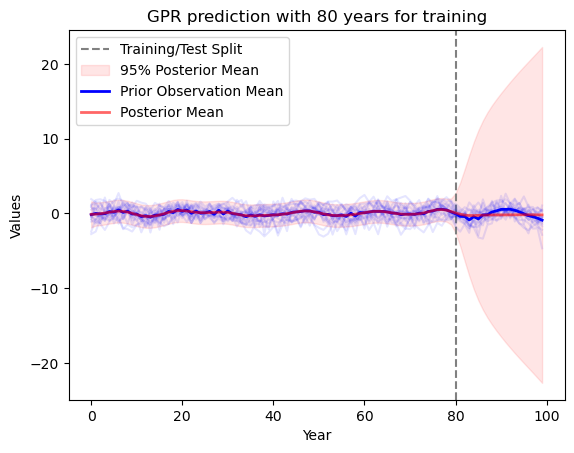

In [50]:
def rqpe3_poly_rqrbf(best_params):
    kernel = (
        C(best_params['c1']) * (DotProduct(sigma_0=best_params['dp_sigma_0']) ** 2) +
        C(best_params['c2']) * RationalQuadratic(length_scale=best_params['rq_ls1'], alpha=best_params['rq_alpha1']) * ExpSineSquared(length_scale=best_params['ls1'], periodicity=best_params['per1']) +
        C(best_params['c3']) * ExpSineSquared(length_scale=best_params['ls2'], periodicity=best_params['per2']) * RationalQuadratic(length_scale=best_params['rq_ls2'], alpha=best_params['rq_alpha2']) +
        C(best_params['c4']) * ExpSineSquared(length_scale=best_params['ls3'], periodicity=best_params['per3']) * RationalQuadratic(length_scale=best_params['rq_ls3'], alpha=best_params['rq_alpha3']) +
        C(best_params['rbf_rq_c']) * RBF(length_scale=best_params['rbf_ls']) * RationalQuadratic(length_scale=best_params['rq_ls_rbf'], alpha=best_params['rq_alpha_rbf']) +
        WhiteKernel(noise_level=best_params['noise'])
    )
    return kernel

pbounds = {
    'c1': (1e-1, 1e1),
    'c2': (1e-1, 1e1),
    'c3': (1e-1, 1e1),
    'c4': (1e-1, 1e1),
    'ls1': (1e-2, 1e1),
    'per1': (10, 30),
    'ls2': (1e-2, 1e1),
    'per2': (10, 30),
    'ls3': (1e-2, 1e1),
    'per3': (10, 30),
    'noise': (1e-3, 1e1),
    'dp_sigma_0': (1e-3, 1e1),
    'rq_alpha1': (1e-2, 1e2),
    'rq_ls1': (1e-2, 1e1),
    'rq_alpha2': (1e-2, 1e2),
    'rq_ls2': (1e-2, 1e1),
    'rq_alpha3': (1e-2, 1e2),
    'rq_ls3': (1e-2, 1e1),
    'rbf_rq_c': (1e-1, 1e1),
    'rbf_ls': (1e-2, 1e1),
    'rq_alpha_rbf': (1e-2, 1e2),
    'rq_ls_rbf': (1e-2, 1e1),
}
gpr_model(mod_ids, 80, rainfall_yearly, pbounds, rqpe3_poly_rqrbf)

Optimization Progress:   0%|          | 0/200 [00:00<?, ?it/s]

|   iter    |  target   |    c1     |    c2     |    c3     |    c4     |    c5     |    c6     |    ls1    |    ls2    |    ls3    |    ls4    |    ls5    |   noise   |   per1    |   per2    |   per3    |  rbf_ls   | rbf_rq_c  | rq_alpha1 | rq_alp... |  rq_ls1   | rq_ls_rbf |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -3.075e+0 |  3.808    |  9.512    |  7.347    |  6.027    |  1.645    |  1.644    |  0.5903   |  8.663    |  6.015    |  7.084    |  0.2156   |  9.699    |  26.65    |  14.25    |  13.64    |  1.842    |  3.112    |  52.48    |  43.2     |  2.919    |  6.122    |
|  2        | -2.181e+0 |  1.481    |  2.992    |  3.727    |  4.615    |  7.873    |  2.077    |  5.147    |  5.928    |  0.474    |  6.079    |  1.714    |  0.6515 

Optimization Progress:   0%|          | 0/200 [00:13<?, ?it/s]

|  100      | -2.932e+0 |  7.743    |  0.369    |  0.7455   |  4.693    |  9.101    |  5.433    |  4.983    |  1.064    |  6.571    |  8.223    |  3.81     |  7.756    |  29.29    |  14.08    |  20.47    |  2.879    |  7.949    |  57.76    |  63.46    |  7.981    |  3.966    |
An error occurred during optimization: 'x0' must only have one dimension.
Best parameters found during the optimization process:  {'c1': 3.795192737130467, 'c2': 2.3499693099052, 'c3': 0.824639645307592, 'c4': 6.074141074475641, 'c5': 6.715306705694661, 'c6': 6.232954425495183, 'ls1': 4.640305497567717, 'ls2': 3.804059943990506, 'ls3': 8.634703159222534, 'ls4': 5.195627033510818, 'ls5': 4.7970269575210125, 'noise': 0.25739501599855047, 'per1': 16.824956552523126, 'per2': 17.60391237571714, 'per3': 17.976455617938008, 'rbf_ls': 5.80592196858105, 'rbf_rq_c': 5.3826652125960965, 'rq_alpha1': 60.79443022841652, 'rq_alpha_rbf': 76.4906773215974, 'rq_ls1': 8.131727529773773, 'rq_ls_rbf': 7.184049531502679}


total_lml_train: -1677.6742614297032
total_lml_test: -445.84391912070936
total_lml_full: -2106.788810925497
best kernel is: 1.95**2 * RationalQuadratic(alpha=60.8, length_scale=8.13) + 2.32**2 * RBF(length_scale=5.81) * RationalQuadratic(alpha=76.5, length_scale=7.18) + 1.53**2 * ExpSineSquared(length_scale=4.64, periodicity=16.8) + 0.908**2 * ExpSineSquared(length_scale=3.8, periodicity=17.6) + 2.46**2 * ExpSineSquared(length_scale=8.63, periodicity=18) + 2.59**2 * RBF(length_scale=5.2) + 2.5**2 * RBF(length_scale=4.8) + WhiteKernel(noise_level=0.257)


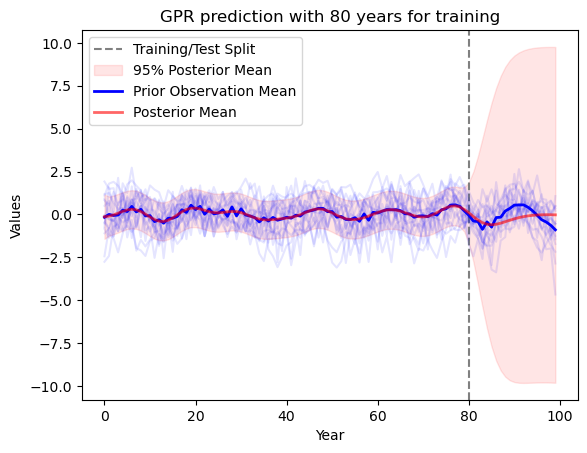

In [51]:
def pe3_rbf2_rqrbf_rq(best_params):
    kernel = (
        C(best_params['c1']) * RationalQuadratic(length_scale=best_params['rq_ls1'], alpha=best_params['rq_alpha1']) +
        C(best_params['rbf_rq_c']) * RBF(length_scale=best_params['rbf_ls']) * RationalQuadratic(length_scale=best_params['rq_ls_rbf'], alpha=best_params['rq_alpha_rbf']) +
        C(best_params['c2']) * ExpSineSquared(length_scale=best_params['ls1'], periodicity=best_params['per1']) +
        C(best_params['c3']) * ExpSineSquared(length_scale=best_params['ls2'], periodicity=best_params['per2']) +
        C(best_params['c4']) * ExpSineSquared(length_scale=best_params['ls3'], periodicity=best_params['per3']) +
        C(best_params['c5']) * RBF(length_scale=best_params['ls4']) +
        C(best_params['c6']) * RBF(length_scale=best_params['ls5']) +
        WhiteKernel(noise_level=best_params['noise'])
    )
    return kernel

pbounds = {
    'c1': (1e-1, 1e1),
    'c2': (1e-1, 1e1),
    'c3': (1e-1, 1e1),
    'c4': (1e-1, 1e1),
    'c5': (1e-1, 1e1),
    'c6': (1e-1, 1e1),
    'ls1': (1e-2, 1e1),
    'per1': (10, 30),
    'ls2': (1e-2, 1e1),
    'per2': (10, 30),
    'ls3': (1e-2, 1e1),
    'per3': (10, 30),
    'ls4': (1e-2, 1e1),
    'ls5': (1e-2, 1e1),
    'noise': (1e-3, 1e1),
    'rq_alpha1': (1e-2, 1e2),
    'rq_ls1': (1e-2, 1e1),
    'rbf_rq_c': (1e-1, 1e1),
    'rbf_ls': (1e-2, 1e1),
    'rq_alpha_rbf': (1e-2, 1e2),
    'rq_ls_rbf': (1e-2, 1e1),
}

gpr_model(mod_ids, 80, rainfall_yearly, pbounds, pe3_rbf2_rqrbf_rq)

Optimization Progress:   0%|          | 0/200 [00:00<?, ?it/s]

|   iter    |  target   |    c1     |    c2     |    c3     |    c4     |    c5     |    ls1    |    ls2    |    ls3    |    ls4    |   noise   |   per1    |   per2    |  rbf_ls   | rbf_rq_c  | rq_alpha1 | rq_alp... |  rq_ls1   | rq_ls_rbf |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -2.86e+03 |  3.808    |  9.512    |  7.347    |  6.027    |  1.645    |  1.568    |  0.5903   |  8.663    |  6.015    |  7.081    |  10.41    |  29.4     |  8.326    |  2.202    |  18.19    |  18.35    |  3.049    |  5.252    |
|  2        | -2.618e+0 |  4.376    |  2.983    |  6.157    |  1.481    |  2.992    |  3.67     |  4.566    |  7.854    |  2.005    |  5.143    |  21.85    |  10.93    |  6.079    |  1.788    |  6.515    |  94.89    |  9.657    |  8.086    |
|  3        | -2.823e+0 |  3.116

Optimization Progress:   0%|          | 0/200 [00:11<?, ?it/s]

|  100      | -3.148e+0 |  4.669    |  6.408    |  6.628    |  8.962    |  6.403    |  6.143    |  0.6759   |  5.189    |  1.51     |  7.375    |  20.24    |  23.6     |  0.4263   |  0.9394   |  71.64    |  7.218    |  0.7219   |  0.131    |
An error occurred during optimization: 'x0' must only have one dimension.
Best parameters found during the optimization process:  {'c1': 4.255300437568611, 'c2': 6.4214068818744465, 'c3': 4.036184539831663, 'c4': 2.8147305032518335, 'c5': 9.8413787148023, 'ls1': 4.09924672308728, 'ls2': 8.942051044754553, 'ls3': 2.307246512851951, 'ls4': 2.138915993210582, 'noise': 0.3123096947622291, 'per1': 23.033336507517703, 'per2': 17.370526874475225, 'rbf_ls': 8.644938915897974, 'rbf_rq_c': 4.784778076246416, 'rq_alpha1': 96.81966085719303, 'rq_alpha_rbf': 18.560696315155084, 'rq_ls1': 8.687545447876552, 'rq_ls_rbf': 7.7682025593895}


total_lml_train: -2088.358675038517
total_lml_test: -539.5364174256435
total_lml_full: -2604.569287810657
best kernel is: 2.06**2 * RationalQuadratic(alpha=96.8, length_scale=8.69) + 2.19**2 * RBF(length_scale=8.64) * RationalQuadratic(alpha=18.6, length_scale=7.77) + 2.53**2 * ExpSineSquared(length_scale=4.1, periodicity=23) + 2.01**2 * ExpSineSquared(length_scale=8.94, periodicity=17.4) + 1.68**2 * RBF(length_scale=2.31) + 3.14**2 * RBF(length_scale=2.14) + WhiteKernel(noise_level=0.312)


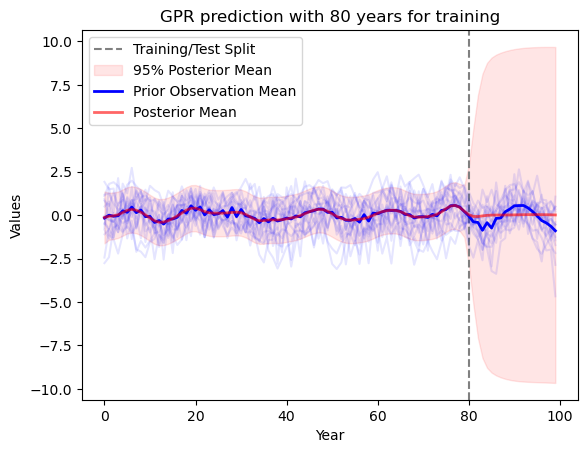

In [52]:
def pe2_rbf2_rqrbf_rq(best_params):
    kernel = (
        C(best_params['c1']) * RationalQuadratic(length_scale=best_params['rq_ls1'], alpha=best_params['rq_alpha1']) +
        C(best_params['rbf_rq_c']) * RBF(length_scale=best_params['rbf_ls']) * RationalQuadratic(length_scale=best_params['rq_ls_rbf'], alpha=best_params['rq_alpha_rbf']) +
        C(best_params['c2']) * ExpSineSquared(length_scale=best_params['ls1'], periodicity=best_params['per1']) +
        C(best_params['c3']) * ExpSineSquared(length_scale=best_params['ls2'], periodicity=best_params['per2']) +
        C(best_params['c4']) * RBF(length_scale=best_params['ls3']) +
        C(best_params['c5']) * RBF(length_scale=best_params['ls4']) +
        WhiteKernel(noise_level=best_params['noise'])
    )
    return kernel

pbounds = {
    'c1': (1e-1, 1e1),
    'c2': (1e-1, 1e1),
    'c3': (1e-1, 1e1),
    'c4': (1e-1, 1e1),
    'c5': (1e-1, 1e1),
    'ls1': (1e-2, 1e1),
    'per1': (10, 30),
    'ls2': (1e-2, 1e1),
    'per2': (10, 30),
    'ls3': (1e-2, 1e1),
    'ls4': (1e-2, 1e1),
    'noise': (1e-3, 1e1),
    'rq_alpha1': (1e-2, 1e2),
    'rq_ls1': (1e-2, 1e1),
    'rbf_rq_c': (1e-1, 1e1),
    'rbf_ls': (1e-2, 1e1),
    'rq_alpha_rbf': (1e-2, 1e2),
    'rq_ls_rbf': (1e-2, 1e1),
}

gpr_model(mod_ids, 80, rainfall_yearly, pbounds, pe2_rbf2_rqrbf_rq)

Optimization Progress:   0%|          | 0/200 [00:00<?, ?it/s]

|   iter    |  target   |    c1     |    c2     |    c3     |    c4     |    ls1    |    ls2    |    ls3    |   noise   |   per1    |   per2    |  rbf_ls   | rbf_rq_c  | rq_alpha1 | rq_alp... |  rq_ls1   | rq_ls_rbf |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -3.374e+0 |  3.808    |  9.512    |  7.347    |  6.027    |  1.569    |  1.568    |  0.5903   |  8.662    |  22.02    |  24.16    |  0.2156   |  9.702    |  83.25    |  21.24    |  1.826    |  1.842    |
|  2        | -2.637e+0 |  3.112    |  5.295    |  4.376    |  2.983    |  6.122    |  1.404    |  2.929    |  3.664    |  19.12    |  25.7     |  2.005    |  5.191    |  59.25    |  4.655    |  6.079    |  1.714    |
|  3        | -3.103e+0 |  0.744    |  9.494    |  9.66     |  8.103    |  3.053    |  0.9857   |  6.845    |  4.402    |  12.44

Optimization Progress:   0%|          | 0/200 [00:10<?, ?it/s]

An error occurred during optimization: 'x0' must only have one dimension.
Best parameters found during the optimization process:  {'c1': 7.004967470525908, 'c2': 6.833393640426974, 'c3': 6.224252644330324, 'c4': 7.551894731620648, 'ls1': 1.5944650018778064, 'ls2': 8.809898884397295, 'ls3': 8.719716842174867, 'noise': 0.2934435830625569, 'per1': 26.516335011295254, 'per2': 12.577397349468903, 'rbf_ls': 3.3578373540488275, 'rbf_rq_c': 7.460731737286917, 'rq_alpha1': 16.08438200587034, 'rq_alpha_rbf': 81.79852274166502, 'rq_ls1': 8.323020437797842, 'rq_ls_rbf': 5.079602660270753}


total_lml_train: -1824.0754142969577
total_lml_test: -477.7566208554979
total_lml_full: -2275.606390633038
best kernel is: 2.65**2 * RationalQuadratic(alpha=16.1, length_scale=8.32) + 2.73**2 * RBF(length_scale=3.36) * RationalQuadratic(alpha=81.8, length_scale=5.08) + 2.61**2 * ExpSineSquared(length_scale=1.59, periodicity=26.5) + 2.49**2 * ExpSineSquared(length_scale=8.81, periodicity=12.6) + 2.75**2 * RBF(length_scale=8.72) + WhiteKernel(noise_level=0.293)


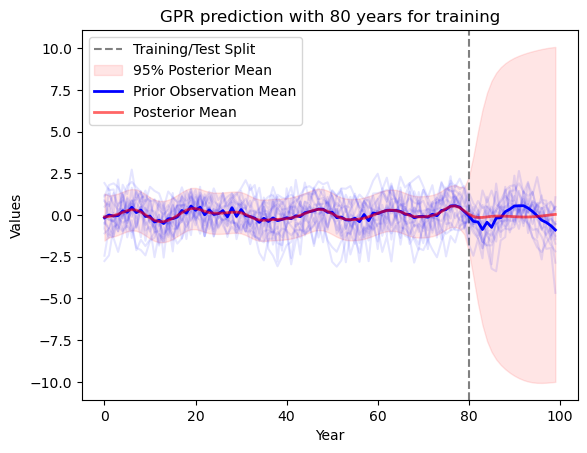

In [53]:
def pe2_rbf1_rqrbf_rq(best_params):
    kernel = (
        C(best_params['c1']) * RationalQuadratic(length_scale=best_params['rq_ls1'], alpha=best_params['rq_alpha1']) +
        C(best_params['rbf_rq_c']) * RBF(length_scale=best_params['rbf_ls']) * RationalQuadratic(length_scale=best_params['rq_ls_rbf'], alpha=best_params['rq_alpha_rbf']) +
        C(best_params['c2']) * ExpSineSquared(length_scale=best_params['ls1'], periodicity=best_params['per1']) +
        C(best_params['c3']) * ExpSineSquared(length_scale=best_params['ls2'], periodicity=best_params['per2']) +
        C(best_params['c4']) * RBF(length_scale=best_params['ls3']) +
        WhiteKernel(noise_level=best_params['noise'])
    )
    return kernel

pbounds = {
    'c1': (1e-1, 1e1),
    'c2': (1e-1, 1e1),
    'c3': (1e-1, 1e1),
    'c4': (1e-1, 1e1),
    'ls1': (1e-2, 1e1),
    'per1': (10, 30),
    'ls2': (1e-2, 1e1),
    'per2': (10, 30),
    'ls3': (1e-2, 1e1),
    'noise': (1e-3, 1e1),
    'rq_alpha1': (1e-2, 1e2),
    'rq_ls1': (1e-2, 1e1),
    'rbf_rq_c': (1e-1, 1e1),
    'rbf_ls': (1e-2, 1e1),
    'rq_alpha_rbf': (1e-2, 1e2),
    'rq_ls_rbf': (1e-2, 1e1),
}

gpr_model(mod_ids, 80, rainfall_yearly, pbounds, pe2_rbf1_rqrbf_rq)


Optimization Progress:   0%|          | 0/200 [00:00<?, ?it/s]

|   iter    |  target   |    c1     |    c2     |    c3     |    c4     |    ls1    |    ls2    |    ls3    |   noise   |   per1    |   per2    |  rbf_ls1  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -3.153e+0 |  3.808    |  9.512    |  7.347    |  6.027    |  1.569    |  1.568    |  0.5903   |  8.662    |  22.02    |  24.16    |  0.2156   |
|  2        | -2.761e+0 |  9.702    |  8.341    |  2.202    |  1.9      |  1.842    |  3.049    |  5.252    |  4.32     |  15.82    |  22.24    |  1.404    |
|  3        | -2.279e+0 |  2.992    |  3.727    |  4.615    |  7.873    |  2.005    |  5.147    |  5.928    |  0.4655   |  22.15    |  13.41    |  0.6599   |
|  4        | -2.032e+0 |  9.494    |  9.66     |  8.103    |  3.116    |  0.9857   |  6.845    |  4.407    |  1.221    |  19.9     |  10.69    |  9.094    |
|  5        | -2.729e+0 |  2.662    |  6.659    |  3

Optimization Progress:   0%|          | 0/200 [00:07<?, ?it/s]

An error occurred during optimization: 'x0' must only have one dimension.
Best parameters found during the optimization process:  {'c1': 9.302338528053475, 'c2': 8.323132137098519, 'c3': 9.653766415598474, 'c4': 1.330542512506893, 'ls1': 7.311366077284406, 'ls2': 9.384021163642169, 'ls3': 1.8205183309949449, 'noise': 0.6658961774004082, 'per1': 24.82241298580118, 'per2': 21.489462263598238, 'rbf_ls1': 8.419869479815137}


total_lml_train: -1829.7817336434923
total_lml_test: -475.8209235490189
total_lml_full: -2284.3505568274827
best kernel is: 3.05**2 * RBF(length_scale=8.42) + 2.88**2 * ExpSineSquared(length_scale=7.31, periodicity=24.8) + 3.11**2 * ExpSineSquared(length_scale=9.38, periodicity=21.5) + 1.15**2 * RBF(length_scale=1.82) + WhiteKernel(noise_level=0.666)


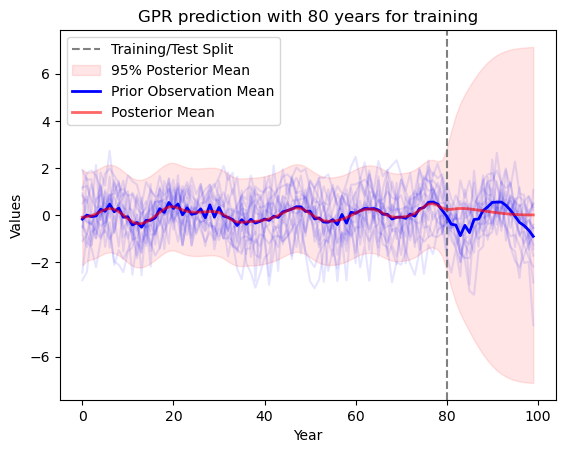

In [54]:
def pe2_rbf2(best_params):
    kernel = (
        C(best_params['c1']) * RBF(length_scale=best_params['rbf_ls1']) +
        C(best_params['c2']) * ExpSineSquared(length_scale=best_params['ls1'], periodicity=best_params['per1']) +
        C(best_params['c3']) * ExpSineSquared(length_scale=best_params['ls2'], periodicity=best_params['per2']) +
        C(best_params['c4']) * RBF(length_scale=best_params['ls3']) +
        WhiteKernel(noise_level=best_params['noise'])
    )
    return kernel

pbounds = {
    'c1': (1e-1, 1e1),
    'c2': (1e-1, 1e1),
    'c3': (1e-1, 1e1),
    'c4': (1e-1, 1e1),
    'ls1': (1e-2, 1e1),
    'per1': (10, 30),
    'ls2': (1e-2, 1e1),
    'per2': (10, 30),
    'ls3': (1e-2, 1e1),
    'rbf_ls1': (1e-2, 1e1),
    'noise': (1e-3, 1e1)
}

gpr_model(mod_ids, 80, rainfall_yearly, pbounds, pe2_rbf2)

Optimization Progress:   0%|          | 0/200 [00:00<?, ?it/s]

|   iter    |  target   |    c1     |    c2     |    c3     |    c4     |    c5     |    ls1    |    ls2    |   noise   |   per1    |   per2    |  rbf_ls1  |  rbf_ls2  |  rbf_ls3  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -3.044e+0 |  3.808    |  9.512    |  7.347    |  6.027    |  1.645    |  1.568    |  0.5903   |  8.662    |  22.02    |  24.16    |  0.2156   |  9.699    |  8.326    |
|  2        | -2.624e+0 |  2.202    |  1.9      |  1.916    |  3.112    |  5.295    |  4.325    |  2.919    |  6.119    |  12.79    |  15.84    |  3.67     |  4.566    |  7.854    |
|  3        | -3.059e+0 |  2.077    |  5.191    |  5.965    |  0.5599   |  6.115    |  1.714    |  0.6599   |  9.489    |  29.31    |  26.17    |  3.053    |  0.9857   |  6.845    |
|  4        | -2.442e+0 |  4.458    |  1.308    |  5.002    |  0.4404   |  9.102    |  2.5

Optimization Progress:   0%|          | 0/200 [00:08<?, ?it/s]

|  100      | -2.82e+03 |  3.571    |  0.4287   |  0.8779   |  4.03     |  1.414    |  5.68     |  6.898    |  8.006    |  14.0     |  13.35    |  1.055    |  6.368    |  7.068    |
An error occurred during optimization: 'x0' must only have one dimension.
Best parameters found during the optimization process:  {'c1': 5.440963794515838, 'c2': 7.928159331905739, 'c3': 3.2556497790274923, 'c4': 6.29632462672639, 'c5': 8.871179707538253, 'ls1': 6.162473249941223, 'ls2': 2.337265152788801, 'noise': 0.24498341478382368, 'per1': 27.401977478018598, 'per2': 10.425388217007743, 'rbf_ls1': 8.748269710115151, 'rbf_ls2': 5.294081968931848, 'rbf_ls3': 9.391286308143833}


total_lml_train: -1753.8375994013209
total_lml_test: -466.5327922401687
total_lml_full: -2207.592058187135
best kernel is: 2.33**2 * RBF(length_scale=8.75) + 2.82**2 * RBF(length_scale=5.29) + 1.8**2 * RBF(length_scale=9.39) + 2.51**2 * ExpSineSquared(length_scale=6.16, periodicity=27.4) + 2.98**2 * ExpSineSquared(length_scale=2.34, periodicity=10.4) + WhiteKernel(noise_level=0.245)


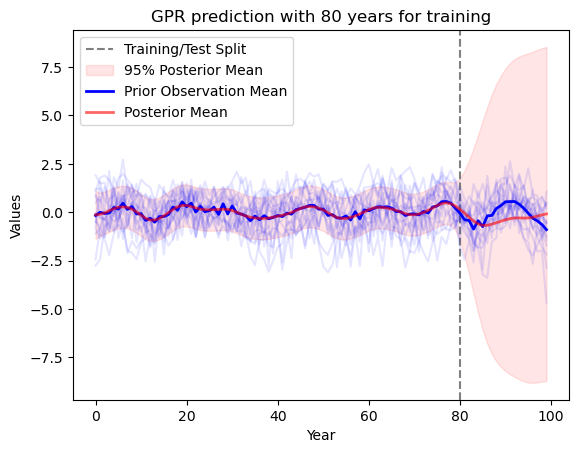

In [55]:
def pe3_rbf2(best_params):
    kernel = (
        C(best_params['c1']) * RBF(length_scale=best_params['rbf_ls1']) +
        C(best_params['c2']) * RBF(length_scale=best_params['rbf_ls2']) +
        C(best_params['c3']) * RBF(length_scale=best_params['rbf_ls3']) +
        C(best_params['c4']) * ExpSineSquared(length_scale=best_params['ls1'], periodicity=best_params['per1']) +
        C(best_params['c5']) * ExpSineSquared(length_scale=best_params['ls2'], periodicity=best_params['per2']) +
        WhiteKernel(noise_level=best_params['noise'])
    )
    return kernel

pbounds = {
    'c1': (1e-1, 1e1),
    'c2': (1e-1, 1e1),
    'c3': (1e-1, 1e1),
    'c4': (1e-1, 1e1),
    'c5': (1e-1, 1e1),
    'ls1': (1e-2, 1e1),
    'per1': (10, 30),
    'ls2': (1e-2, 1e1),
    'per2': (10, 30),
    'rbf_ls1': (1e-2, 1e1),
    'rbf_ls2': (1e-2, 1e1),
    'rbf_ls3': (1e-2, 1e1),
    'noise': (1e-3, 1e1)
}

gpr_model(mod_ids, 80, rainfall_yearly, pbounds, pe3_rbf2)


Optimization Progress:   0%|          | 0/200 [00:00<?, ?it/s]

|   iter    |  target   |    c1     |    c2     |    c3     |    c4     |    c5     |    ls1    |    ls2    |    ls3    |   noise   |   per1    |   per2    |   per3    |  rbf_ls   | rbf_rq_ls | rq_alpha  |   rq_ls   |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -2.967e+0 |  3.808    |  9.512    |  7.347    |  6.027    |  1.645    |  1.568    |  0.5903   |  8.663    |  6.012    |  24.16    |  10.41    |  29.4     |  8.326    |  2.131    |  18.19    |  1.842    |
|  2        | -2.839e+0 |  3.112    |  5.295    |  4.376    |  2.983    |  6.157    |  1.404    |  2.929    |  3.67     |  4.561    |  25.7     |  13.99    |  20.28    |  5.928    |  0.474    |  60.76    |  1.714    |
|  3        | -2.068e+0 |  0.744    |  9.494    |  9.66     |  8.103    |  3.116    |  0.9857   |  6.845    |  4.407    |  1.221

Optimization Progress:   0%|          | 0/200 [00:10<?, ?it/s]

|  99       | -1.969e+0 |  6.276    |  4.573    |  5.907    |  1.763    |  7.395    |  8.629    |  2.175    |  0.9662   |  0.2374   |  22.84    |  22.14    |  20.93    |  2.327    |  3.915    |  59.45    |  4.973    |
|  100      | -2.303e+0 |  9.879    |  1.451    |  6.982    |  4.103    |  4.339    |  7.179    |  6.927    |  9.913    |  1.285    |  12.08    |  24.49    |  21.57    |  2.749    |  0.8034   |  8.575    |  8.943    |
An error occurred during optimization: 'x0' must only have one dimension.
Best parameters found during the optimization process:  {'c1': 5.071730602279302, 'c2': 5.9943116714684335, 'c3': 0.7640571261454321, 'c4': 7.52460865695186, 'c5': 2.178065371646299, 'ls1': 8.98156235151273, 'ls2': 2.0593450084152516, 'ls3': 1.914970329430029, 'noise': 0.36646012881310075, 'per1': 19.441338902199984, 'per2': 21.29682266525233, 'per3': 11.314172788567047, 'rbf_ls': 7.757520890783155, 'rbf_rq_ls': 4.538355459132796, 'rq_alpha': 52.44378303006472, 'rq_ls': 4.4132198419128

total_lml_train: -1743.1745095341255
total_lml_test: -459.9605165229707
total_lml_full: -2173.302530250115
best kernel is: 2.25**2 * RBF(length_scale=7.76) + 2.45**2 * RBF(length_scale=4.54) * RationalQuadratic(alpha=52.4, length_scale=4.41) + 0.874**2 * ExpSineSquared(length_scale=8.98, periodicity=19.4) + 2.74**2 * ExpSineSquared(length_scale=2.06, periodicity=21.3) + 1.48**2 * ExpSineSquared(length_scale=1.91, periodicity=11.3) + WhiteKernel(noise_level=0.366)


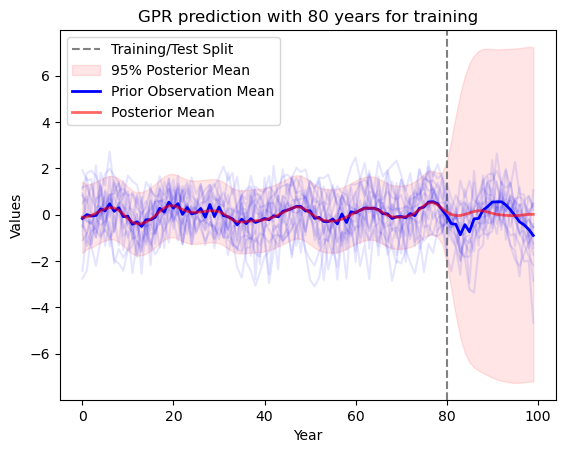

In [56]:
def pe3_rbf1_rqrbf(best_params):
    kernel = (
        C(best_params['c1']) * RBF(length_scale=best_params['rbf_ls']) +
        C(best_params['c2']) * RBF(length_scale=best_params['rbf_rq_ls']) * RationalQuadratic(length_scale=best_params['rq_ls'], alpha=best_params['rq_alpha']) +
        C(best_params['c3']) * ExpSineSquared(length_scale=best_params['ls1'], periodicity=best_params['per1']) +
        C(best_params['c4']) * ExpSineSquared(length_scale=best_params['ls2'], periodicity=best_params['per2']) +
        C(best_params['c5']) * ExpSineSquared(length_scale=best_params['ls3'], periodicity=best_params['per3']) +
        WhiteKernel(noise_level=best_params['noise'])
    )
    return kernel

pbounds = {
    'c1': (1e-1, 1e1),
    'c2': (1e-1, 1e1),
    'c3': (1e-1, 1e1),
    'c4': (1e-1, 1e1),
    'c5': (1e-1, 1e1),
    'ls1': (1e-2, 1e1),
    'per1': (10, 30),
    'ls2': (1e-2, 1e1),
    'per2': (10, 30),
    'ls3': (1e-2, 1e1),
    'per3': (10, 30),
    'rbf_ls': (1e-2, 1e1),
    'rbf_rq_ls': (1e-2, 1e1),
    'rq_ls': (1e-2, 1e1),
    'rq_alpha': (1e-2, 1e2),
    'noise': (1e-3, 1e1)
}

gpr_model(mod_ids, 80, rainfall_yearly, pbounds, pe3_rbf1_rqrbf)

## Poly(PE)

In [57]:
class CustomPolynomialKernel(Kernel):
    def __init__(self, degree=2, periods=[1, 1, 1], include_bias=False):
        self.degree = degree
        self.periods = periods if isinstance(periods, (list, np.ndarray)) else [periods]
        self.include_bias = include_bias
        self.poly = PolynomialFeatures(degree=self.degree, include_bias=self.include_bias)
    
    def periodic_transform(self, X):
        return np.hstack([np.cos(2 * np.pi * X / p) for p in self.periods] +
                         [np.sin(2 * np.pi * X / p) for p in self.periods])
    
    def __call__(self, X, Y=None, eval_gradient=False):
        X_transformed = self.periodic_transform(X)
        if Y is None:
            Y_transformed = X_transformed
        else:
            Y_transformed = self.periodic_transform(Y)
        
        K = self.poly.fit_transform(X_transformed).dot(self.poly.fit_transform(Y_transformed).T)
        
        if eval_gradient:
            K_gradient = np.zeros((X_transformed.shape[0], Y_transformed.shape[0], 0))
            return K, K_gradient
        else:
            return K
    
    def diag(self, X):
        return np.diag(self.__call__(X))
    
    def is_stationary(self):
        return False

Optimization Progress:   0%|          | 0/200 [00:00<?, ?it/s]

|   iter    |  target   | constant1 | constant2 | constant3 | matern_ls | noise_... |    nu     |  periods  | rq_alpha  |   rq_ls   |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        | -2.75e+03 |  374.5    |  950.7    |  732.0    |  59.87    |  1.569    |  0.812    |  11.16    |  1.746    |  60.12    |
|  2        | -2.697e+0 |  708.1    |  20.59    |  969.9    |  83.25    |  2.131    |  0.8636   |  13.67    |  0.6781   |  52.48    |
|  3        | -3.126e+0 |  431.9    |  291.2    |  611.9    |  13.96    |  2.929    |  1.233    |  19.12    |  1.592    |  19.98    |
|  4        | -2.354e+0 |  514.2    |  592.4    |  46.45    |  60.76    |  1.714    |  0.6301   |  28.98    |  1.935    |  80.84    |
|  5        | -2.325e+0 |  304.6    |  97.67    |  684.2    |  44.02    |  1.229    |  1.49     |  10.69    |  1.828    |  25.89    |
|  6        | -2.357e+0 |  662.5    |  311.7    |  520.1    | 

Optimization Progress:   0%|          | 0/200 [00:13<?, ?it/s]

|  100      | -2.948e+0 |  855.7    |  830.2    |  397.2    |  66.81    |  2.058    |  1.086    |  27.93    |  0.1247   |  8.56     |
An error occurred during optimization: 'x0' must only have one dimension.
Best parameters found during the optimization process:  {'constant1': 627.9007615905183, 'constant2': 81.75995018983997, 'constant3': 873.5787505281531, 'matern_ls': 92.088031329176, 'noise_level': 0.6201688189500889, 'nu': 1.0537552962944075, 'periods': 26.124025595861227, 'rq_alpha': 1.521693411728951, 'rq_ls': 18.460256725444168}


total_lml_train: -2089.891314890936
total_lml_test: -664.8996230188808
total_lml_full: -2568.1186312024142
best kernel is: 25.1**2 * CustomPolynomialKernel() + 9.04**2 * RationalQuadratic(alpha=1.52, length_scale=18.5) + 29.6**2 * Matern(length_scale=92.1, nu=1.05) + WhiteKernel(noise_level=0.62)


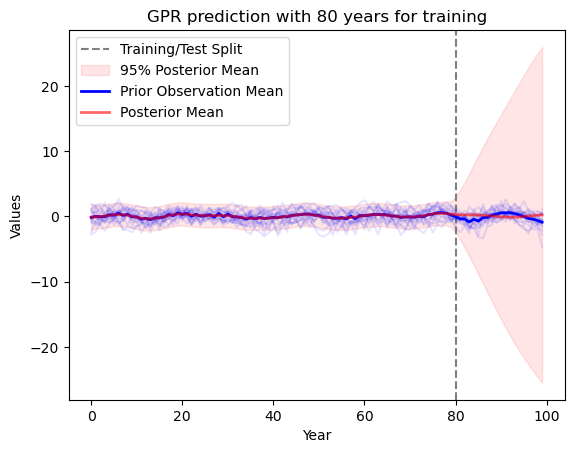

In [58]:
def polype_rq_Matern(best_params):
    custom_poly_kernel = C(best_params['constant1']) * CustomPolynomialKernel(degree=2, periods=best_params['periods'])
    original_kernel = (
        C(best_params['constant2']) * RQ(length_scale=best_params['rq_ls'], alpha=best_params['rq_alpha']) +
        C(best_params['constant3']) * Matern(length_scale=best_params['matern_ls'], nu=best_params['nu']) +
        WhiteKernel(noise_level=best_params['noise_level'])
    )
    return custom_poly_kernel + original_kernel

pbounds = {
    'periods': (10, 30),
    'rq_alpha': (0.1, 2.0),
    'matern_ls': (1e-2, 1e2),
    'noise_level': (1e-2, 1e1),
    'constant1': (1e-3, 1e3),
    'constant2': (1e-3, 1e3),
    'constant3': (1e-3, 1e3),
    'nu': (0.5, 2.5),
    'rq_ls': (1e-2, 1e2)
}
gpr_model(mod_ids, 80, rainfall_yearly, pbounds, polype_rq_Matern)

Optimization Progress:   0%|          | 0/200 [00:00<?, ?it/s]

|   iter    |  target   | constant1 | constant2 | constant3 | constant4 | constant5 | matern... | noise_... |    nu     |  period1  |  period2  |  period3  | rbf_le... | rq_alpha  |   rq_ls   |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -2.928e+0 |  374.5    |  950.7    |  732.0    |  598.7    |  156.0    |  16.44    |  0.5903   |  2.232    |  22.02    |  24.16    |  10.41    |  96.99    |  83.25    |  21.24    |
|  2        | -3.525e+0 |  181.8    |  183.4    |  304.2    |  524.8    |  431.9    |  29.83    |  6.122    |  0.779    |  15.84    |  17.33    |  19.12    |  78.52    |  19.98    |  51.43    |
|  3        | -3.907e+0 |  592.4    |  46.45    |  607.5    |  170.5    |  65.05    |  94.94    |  9.657    |  2.117    |  16.09    |  11.95    |  23.68    |  44.02    |  12.21    |  49.52    |
|  4        | -2.988e+0 |  34.

Optimization Progress:   0%|          | 0/200 [00:15<?, ?it/s]

|  100      | -3.761e+0 |  773.5    |  130.9    |  969.8    |  453.8    |  236.1    |  8.276    |  1.706    |  1.54     |  16.74    |  26.58    |  18.62    |  24.88    |  61.72    |  70.68    |
An error occurred during optimization: 'x0' must only have one dimension.
Best parameters found during the optimization process:  {'constant1': 13.095443493877047, 'constant2': 663.5377084793386, 'constant3': 178.03678883378456, 'constant4': 961.0703563991377, 'constant5': 148.6635790903852, 'matern_length': 42.04778824897535, 'noise_level': 0.8626431841056522, 'nu': 2.4937485036918945, 'period1': 20.04390020662485, 'period2': 21.907700346400876, 'period3': 11.34152954776855, 'rbf_length': 74.9985474352138, 'rq_alpha': 20.99846025362762, 'rq_ls': 89.80644840117697}


total_lml_train: -2454.5524036446072
total_lml_test: -733.4426712006127
total_lml_full: -3025.005503551169
best kernel is: 3.62**2 * CustomPolynomialKernel() + 25.8**2 * RationalQuadratic(alpha=21, length_scale=89.8) + 13.3**2 * Matern(length_scale=42, nu=2.49) + 31**2 * RBF(length_scale=75) + WhiteKernel(noise_level=0.863)


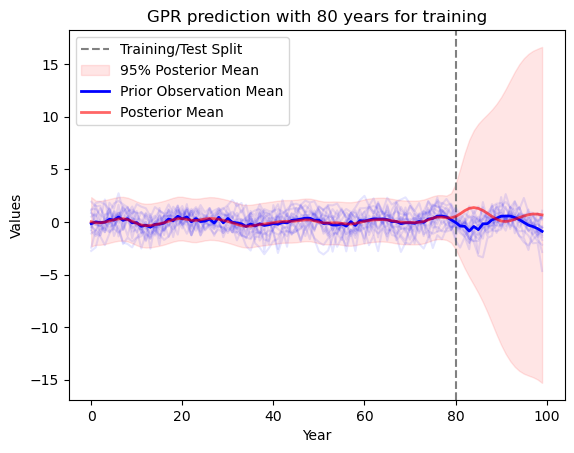

In [59]:
def polype3_rq_matern_rbf(best_params):
    custom_poly_kernel = C(best_params['constant1']) * CustomPolynomialKernel(degree=2, periods=[best_params['period1'], best_params['period2'], best_params['period3']])
    original_kernel = (
        C(best_params['constant2']) * RQ(length_scale=best_params['rq_ls'], alpha=best_params['rq_alpha']) +
        C(best_params['constant3']) * Matern(length_scale=best_params['matern_length'], nu=best_params['nu']) +
        C(best_params['constant4']) * RBF(length_scale=best_params['rbf_length']) +
        WhiteKernel(noise_level=best_params['noise_level'])
    )
    return custom_poly_kernel + original_kernel

pbounds = {
    'period1': (10, 30),
    'period2': (10, 30),
    'period3': (10, 30),
    'rq_alpha': (1e-2, 1e2),
    'matern_length': (1e0, 1e2),
    'noise_level': (1e-2, 1e1),
    'constant1': (1e-3, 1e3),
    'constant2': (1e-3, 1e3),
    'constant3': (1e-3, 1e3),
    'constant4': (1e-3, 1e3),
    'constant5': (1e-3, 1e3),
    'rbf_length': (1e-2, 1e2),
    'nu': (0.5, 2.5),
    'rq_ls': (1e-2, 1e2)
}

gpr_model(mod_ids, 80, rainfall_yearly, pbounds, polype3_rq_matern_rbf)

Optimization Progress:   0%|          | 0/200 [00:00<?, ?it/s]

|   iter    |  target   | constant1 | constant2 | constant3 | constant4 | constant5 | constant6 | matern... | noise_... |    nu     |  period1  |  period2  |  period3  | rbf_le... | rq_alpha  |   rq_ls   |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -1.918e+0 |  0.3752   |  0.9508   |  0.7323   |  0.5991   |  0.1569   |  0.1568   |  1.0      |  0.8675   |  1.702    |  24.16    |  10.41    |  29.4     |  0.8341   |  0.2202   |  0.19     |
|  2        | -1.831e+0 |  0.1842   |  0.3049   |  0.5252   |  0.4325   |  0.2919   |  0.6122   |  1.0      |  0.2992   |  1.233    |  19.12    |  25.7     |  13.99    |  0.5191   |  0.5965   |  0.05599  |
|  3        | -2.06e+03 |  0.6079   |  0.1714   |  0.06599  |  0.9489   |  0.9657   |  0.8086   |  1.0      |  0.1067   |  1.868    |  18.8     |  12.44    |  19.9     |  0.044

Optimization Progress:   0%|          | 0/200 [00:16<?, ?it/s]

|  100      | -1.74e+03 |  0.3671   |  0.3968   |  0.6958   |  0.3892   |  0.4492   |  0.2383   |  1.0      |  0.235    |  0.6464   |  22.07    |  23.36    |  22.39    |  0.4689   |  0.386    |  0.8647   |
An error occurred during optimization: 'x0' must only have one dimension.
Best parameters found during the optimization process:  {'constant1': 0.24090547315941488, 'constant2': 0.07678746478055526, 'constant3': 0.12975084218873859, 'constant4': 0.12891779311881466, 'constant5': 0.15275079081878207, 'constant6': 0.13968834547676073, 'matern_length': 1.0, 'noise_level': 0.1900612835551534, 'nu': 1.1913345666477264, 'period1': 27.935768198120236, 'period2': 19.479232805257446, 'period3': 23.351154770420543, 'rbf_length': 0.18059667248961356, 'rq_alpha': 0.20036612862058406, 'rq_ls': 0.050459930103814075}


total_lml_train: -1519.9762329830742
total_lml_test: -399.01143536268165
total_lml_full: -1947.7301462102694
best kernel is: 0.491**2 * CustomPolynomialKernel() + 0.277**2 * CustomPolynomialKernel() + 0.36**2 * CustomPolynomialKernel() + 0.359**2 * RationalQuadratic(alpha=0.2, length_scale=0.0505) + 0.391**2 * Matern(length_scale=1, nu=1.19) + 0.374**2 * RBF(length_scale=0.181) + WhiteKernel(noise_level=0.19)


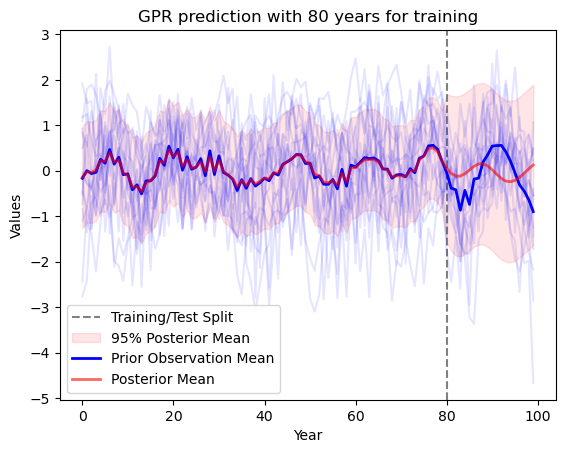

In [60]:
def polype3_rq_matern_rbf_true(best_params):
    custom_poly_kernel1 = C(best_params['constant1']) * CustomPolynomialKernel(degree=2, periods=best_params['period1'])
    custom_poly_kernel2 = C(best_params['constant2']) * CustomPolynomialKernel(degree=2, periods=best_params['period2'])
    custom_poly_kernel3 = C(best_params['constant3']) * CustomPolynomialKernel(degree=2, periods=best_params['period3'])
    
    original_kernel = (
        C(best_params['constant4']) * RQ(length_scale=best_params['rq_ls'], alpha=best_params['rq_alpha']) +
        C(best_params['constant5']) * Matern(length_scale=best_params['matern_length'], nu=best_params['nu']) +
        C(best_params['constant6']) * RBF(length_scale=best_params['rbf_length']) +
        WhiteKernel(noise_level=best_params['noise_level'])
    )
    
    return custom_poly_kernel1 + custom_poly_kernel2 + custom_poly_kernel3 + original_kernel

pbounds = {
    'period1': (10, 30),
    'period2': (10, 30),
    'period3': (10, 30),
    'rq_alpha': (1e-2, 1),
    'matern_length': (1e0, 1),
    'noise_level': (1e-2, 1),
    'constant1': (1e-3, 1),
    'constant2': (1e-3, 1),
    'constant3': (1e-3, 1),
    'constant4': (1e-3, 1),
    'constant5': (1e-3, 1),
    'constant6': (1e-3, 1),
    'rbf_length': (1e-2, 1),
    'nu': (0.5, 2.5),
    'rq_ls': (1e-2, 1)
}

gpr_model(mod_ids, 80, rainfall_yearly, pbounds, polype3_rq_matern_rbf_true)

Optimization Progress:   0%|          | 0/200 [00:00<?, ?it/s]

|   iter    |  target   | constant1 | constant2 | constant3 | constant4 | noise_... |    nu     |  period1  |  period2  |  period3  | rbf_le... | rq_alpha  |   rq_ls   |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -1.766e+0 |  0.3752   |  0.9508   |  0.7323   |  0.5991   |  0.1645   |  0.812    |  11.16    |  27.32    |  22.02    |  70.81    |  0.03038  |  96.99    |
|  2        | -1.805e+0 |  0.8326   |  0.2131   |  0.1826   |  0.1842   |  0.3112   |  1.55     |  18.64    |  15.82    |  22.24    |  13.96    |  0.2992   |  36.64    |
|  3        | -1.872e+0 |  0.4566   |  0.7854   |  0.2005   |  0.5147   |  0.5965   |  0.5929   |  22.15    |  13.41    |  11.3     |  94.89    |  0.966    |  80.84    |
|  4        | -1.774e+0 |  0.3053   |  0.09857  |  0.6845   |  0.4407   |  0.1308   |  1.49     |  10.69    |  28.19    |  15.18    |  66.26    |  0.3

Optimization Progress:   0%|          | 0/200 [00:11<?, ?it/s]

|  99       | -2.047e+0 |  0.7801   |  0.1079   |  0.7613   |  0.5417   |  0.9634   |  1.184    |  22.65    |  28.64    |  12.05    |  93.72    |  0.691    |  6.793    |
|  100      | -1.656e+0 |  0.3017   |  0.7085   |  0.06828  |  0.5826   |  0.3524   |  1.742    |  10.91    |  27.43    |  29.47    |  96.89    |  0.7522   |  13.02    |
An error occurred during optimization: 'x0' must only have one dimension.
Best parameters found during the optimization process:  {'constant1': 0.12891779311881466, 'constant2': 0.15275079081878207, 'constant3': 0.13968834547676073, 'constant4': 0.6412338700584114, 'noise_level': 0.1900612835551534, 'nu': 1.1913345666477264, 'period1': 27.935768198120236, 'period2': 19.479232805257446, 'period3': 23.351154770420543, 'rbf_length': 17.240263921450968, 'rq_alpha': 0.20036612862058406, 'rq_ls': 4.0964529404852215}


total_lml_train: -1506.1135291503874
total_lml_test: -395.15630073992475
total_lml_full: -1955.1048586464594
best kernel is: 0.359**2 * CustomPolynomialKernel() + 0.391**2 * RationalQuadratic(alpha=0.2, length_scale=4.1) * RBF(length_scale=17.2) + 0.374**2 * Matern(length_scale=0.641, nu=1.19) + WhiteKernel(noise_level=0.19)


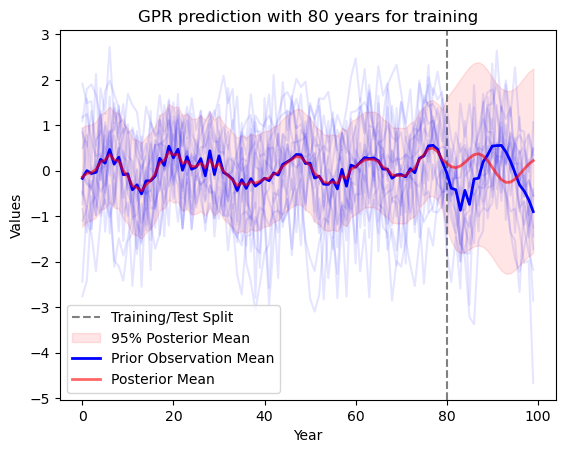

In [61]:
def polype3_rqrbf_matern(best_params):
    custom_poly_kernel = C(best_params['constant1']) * CustomPolynomialKernel(
        degree=2, periods=[best_params['period1'], best_params['period2'], best_params['period3']]
    )
    combined_kernel = (
        C(best_params['constant2']) * RQ(length_scale=best_params['rq_ls'], alpha=best_params['rq_alpha']) *
        RBF(length_scale=best_params['rbf_length']) +
        C(best_params['constant3']) * Matern(length_scale=best_params['constant4'], nu=best_params['nu']) +
        WhiteKernel(noise_level=best_params['noise_level'])
    )
    return custom_poly_kernel + combined_kernel

pbounds = {
    'period1': (10, 30),
    'period2': (10, 30),
    'period3': (10, 30),
    'rq_alpha': (1e-2, 1),
    'rbf_length': (1e-2, 1e2),
    'noise_level': (1e-2, 1),
    'constant1': (1e-3, 1),
    'constant2': (1e-3, 1),
    'constant3': (1e-3, 1),
    'constant4': (1e-3, 1),
    'nu': (0.5, 2.5),
    'rq_ls': (1e-2, 1e2)
}

gpr_model(mod_ids, 80, rainfall_yearly, pbounds, polype3_rqrbf_matern)

Optimization Progress:   0%|          | 0/200 [00:00<?, ?it/s]

|   iter    |  target   | constant1 | constant2 | constant3 | constant4 | noise_... |  period1  |  period2  |  period3  | rbf_le... | rbf_le... | rq_alpha  |   rq_ls   |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -3.307e+0 |  374.5    |  950.7    |  732.0    |  598.7    |  1.569    |  13.12    |  11.16    |  27.32    |  60.12    |  70.81    |  2.068    |  96.99    |
|  2        | -3.366e+0 |  832.4    |  212.3    |  181.8    |  183.4    |  3.049    |  20.5     |  18.64    |  15.82    |  61.19    |  13.96    |  29.22    |  36.64    |
|  3        | -3.901e+0 |  456.1    |  785.2    |  199.7    |  514.2    |  5.928    |  10.93    |  22.15    |  13.41    |  6.515    |  94.89    |  96.56    |  80.84    |
|  4        | -3.133e+0 |  304.6    |  97.67    |  684.2    |  440.2    |  1.229    |  19.9     |  10.69    |  28.19    |  25.89    |  66.26    |  31.

Optimization Progress:   0%|          | 0/200 [00:07<?, ?it/s]

|  99       | -3.95e+03 |  779.8    |  107.0    |  761.0    |  541.3    |  9.63     |  16.84    |  22.65    |  28.64    |  10.26    |  93.72    |  68.79    |  6.793    |
|  100      | -3.454e+0 |  301.0    |  708.2    |  67.35    |  582.2    |  3.465    |  22.42    |  10.91    |  27.43    |  97.35    |  96.89    |  74.97    |  13.02    |
An error occurred during optimization: 'x0' must only have one dimension.
Best parameters found during the optimization process:  {'constant1': 11.354633413774302, 'constant2': 468.66117333348427, 'constant3': 56.30421937856167, 'constant4': 118.81879745015566, 'noise_level': 1.1840872053032778, 'period1': 22.984206042321272, 'period2': 24.920897585308467, 'period3': 21.667375301943192, 'rbf_length1': 96.21763312196944, 'rbf_length2': 37.493309246575166, 'rq_alpha': 28.578351507323255, 'rq_ls': 86.86122682766414}


total_lml_train: -2149.0324723816634
total_lml_test: -620.8993078106602
total_lml_full: -2685.1674871014425
best kernel is: 3.37**2 * CustomPolynomialKernel() + 21.6**2 * RationalQuadratic(alpha=28.6, length_scale=86.9) * RBF(length_scale=96.2) + 7.5**2 * RBF(length_scale=37.5) + WhiteKernel(noise_level=1.18)


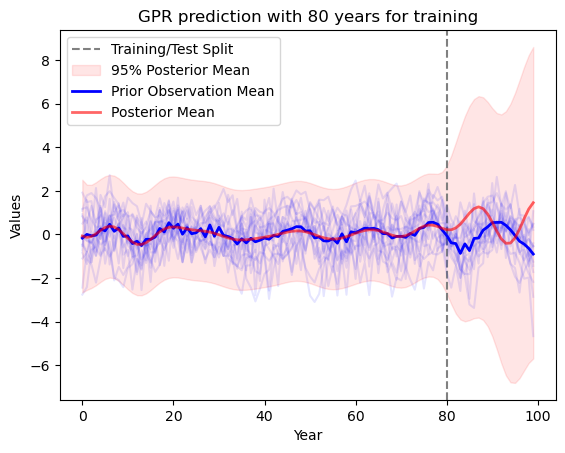

In [62]:
def polype3_rqrbf_rbf(best_params):
    custom_poly_kernel = C(best_params['constant1']) * CustomPolynomialKernel(
        degree=2, periods=[best_params['period1'], best_params['period2'], best_params['period3']]
    )
    combined_kernel = (
        C(best_params['constant2']) * RQ(length_scale=best_params['rq_ls'], alpha=best_params['rq_alpha']) *
        RBF(length_scale=best_params['rbf_length1']) +
        C(best_params['constant3']) * RBF(length_scale=best_params['rbf_length2']) +
        WhiteKernel(noise_level=best_params['noise_level'])
    )
    return custom_poly_kernel + combined_kernel

pbounds = {
    'period1': (10, 30),
    'period2': (10, 30),
    'period3': (10, 30),
    'rq_alpha': (1e-2, 1e2),
    'rbf_length1': (1e-2, 1e2),
    'rbf_length2': (1e-2, 1e2),
    'noise_level': (1e-2, 1e1),
    'constant1': (1e-3, 1e3),
    'constant2': (1e-3, 1e3),
    'constant3': (1e-3, 1e3),
    'constant4': (1e-3, 1e3),
    'rq_ls': (1e-2, 1e2)
}

gpr_model(mod_ids, 80, rainfall_yearly, pbounds, polype3_rqrbf_rbf)

Optimization Progress:   0%|          | 0/200 [00:00<?, ?it/s]

|   iter    |  target   | constant1 | constant2 | constant3 | constant4 | noise_... |  period1  |  period2  | rbf_le... | rbf_le... | rq_alpha  |   rq_ls   |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -3.878e+0 |  374.5    |  950.7    |  732.0    |  598.7    |  1.569    |  13.12    |  11.16    |  86.62    |  60.12    |  70.81    |  2.068    |
|  2        | -2.759e+0 |  969.9    |  832.4    |  212.3    |  181.8    |  1.842    |  16.08    |  20.5     |  43.2     |  29.13    |  61.19    |  13.96    |
|  3        | -3.005e+0 |  292.1    |  366.4    |  456.1    |  785.2    |  2.005    |  20.28    |  21.85    |  4.655    |  60.76    |  17.06    |  6.515    |
|  4        | -2.63e+03 |  948.9    |  965.6    |  808.4    |  304.6    |  0.9857   |  23.68    |  18.8     |  12.21    |  49.52    |  3.449    |  90.93    |
|  5        | -2.972e+0 |  258.8    |  662.5    |  3

Optimization Progress:   0%|          | 0/200 [00:09<?, ?it/s]

|  100      | -3.126e+0 |  231.7    |  942.7    |  649.6    |  607.7    |  5.132    |  14.61    |  13.53    |  22.06    |  18.65    |  77.96    |  35.02    |
An error occurred during optimization: 'x0' must only have one dimension.
Best parameters found during the optimization process:  {'constant1': 795.1863995825089, 'constant2': 270.83298042982295, 'constant3': 438.9719817342154, 'constant4': 78.45730288588462, 'noise_level': 0.26325392672042053, 'period1': 29.252968293558503, 'period2': 26.719602410244118, 'rbf_length1': 69.60046086730887, 'rbf_length2': 40.901204911982845, 'rq_alpha': 17.33769906388387, 'rq_ls': 15.652139896681893}


total_lml_train: -2220.735947345036
total_lml_test: -641.3213278346986
total_lml_full: -2849.340906912904
best kernel is: 28.2**2 * CustomPolynomialKernel() + 16.5**2 * CustomPolynomialKernel() + 21**2 * RationalQuadratic(alpha=17.3, length_scale=15.7) * RBF(length_scale=69.6) + 8.86**2 * RBF(length_scale=40.9) + WhiteKernel(noise_level=0.263)


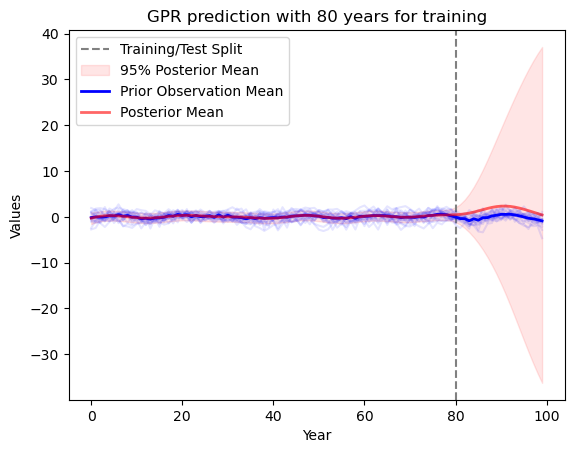

In [63]:
def polype3_rqrbf_rbf(best_params):
    custom_poly_kernel1 = C(best_params['constant1']) * CustomPolynomialKernel(
        degree=2, periods=best_params['period1']
    )
    custom_poly_kernel2 = C(best_params['constant2']) * CustomPolynomialKernel(
        degree=2, periods=best_params['period2']
    )
    combined_kernel = (
        custom_poly_kernel1 +
        custom_poly_kernel2 +
        C(best_params['constant3']) * RQ(length_scale=best_params['rq_ls'], alpha=best_params['rq_alpha']) * 
        RBF(length_scale=best_params['rbf_length1']) +
        C(best_params['constant4']) * RBF(length_scale=best_params['rbf_length2']) +
        WhiteKernel(noise_level=best_params['noise_level'])
    )
    return combined_kernel

pbounds = {
    'period1': (10, 30),
    'period2': (10, 30),
    'rq_alpha': (1e-2, 1e2),
    'rbf_length1': (1e-2, 1e2),
    'rbf_length2': (1e-2, 1e2),
    'noise_level': (1e-2, 1e1),
    'constant1': (1e-3, 1e3),
    'constant2': (1e-3, 1e3),
    'constant3': (1e-3, 1e3),
    'constant4': (1e-3, 1e3),
    'rq_ls': (1e-2, 1e2)
}

gpr_model(mod_ids, 80, rainfall_yearly, pbounds, polype3_rqrbf_rbf)